<a href="https://colab.research.google.com/github/JunFin/FishModel/blob/main/Plots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# === Параметры (по умолчанию — как в численном примере статьи) ===
m = 1.0
J = 1.0
K = 1.0
k_b = 0.5
l_b = -3.0
l_a = -2
k_theta = 2.0

# === Матрица A(U) из статьи ===
def A_matrix(U, l_a, m=m, J=J, K=K, k_b=k_b, l_b=l_b, k_theta=k_theta):
    return np.array([
        [0.0,                       1.0,                                      0.0,                                   0.0],
        [k_b/m,                -K*U/m,                      (k_b*l_b + K*U*U)/m,                                   0.0],
        [0.0,                       0.0,                                      0.0,                                   1.0],
        [k_b*l_b/J,        -(l_a*K*U)/J,   (-k_theta + (l_b*l_b)*k_b + l_a*K*U*U)/J,                                 0.0]
    ], dtype=float)


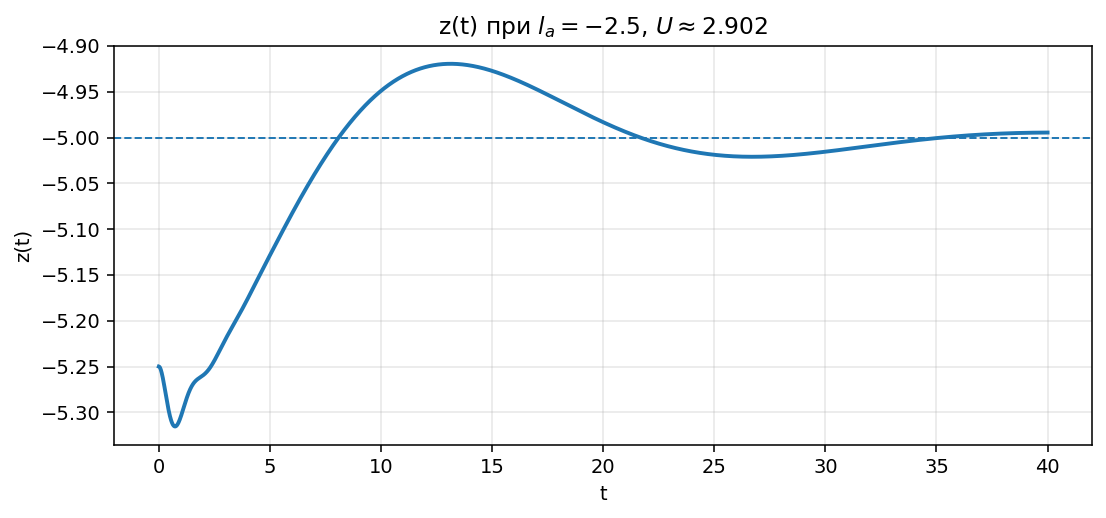

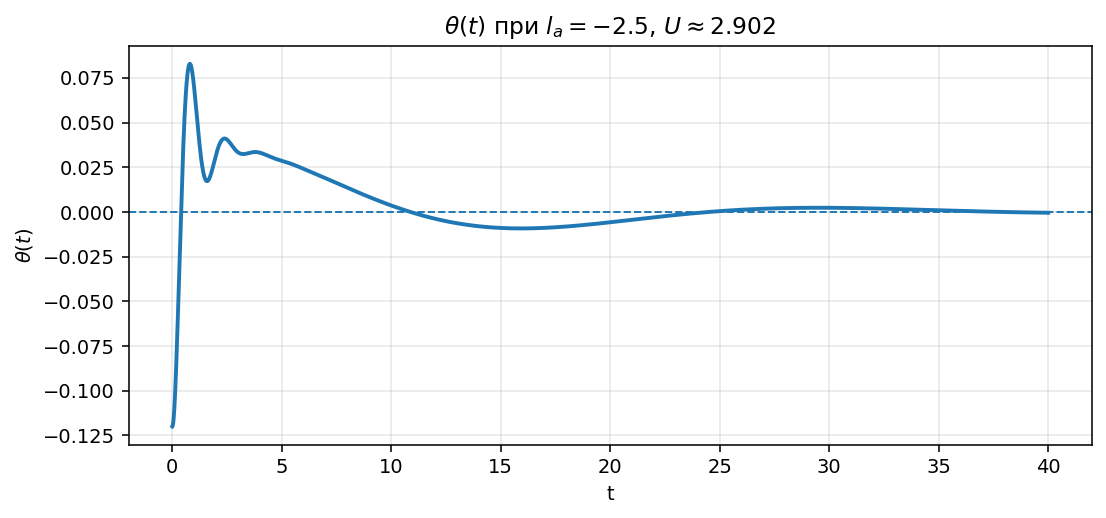

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp


# --- 0) Базовые (абсолютные) значения равновесия. Можно менять при необходимости ---
z_eq = -5      # базовый уровень z*
theta_eq = 0  # базовый угол θ*

# --- 1) Если временные ряды дельт отсутствуют, пересчитаем ---
need_recompute = False
for name in ['t', 'z_t', 'th_t']:
    if name not in globals():
        need_recompute = True
        break

if need_recompute:
    # Страховка: если U_sim или l_a_fixed отсутствуют, зададим типичные из предыдущих блоков
    if 'l_a_fixed' not in globals():
        l_a_fixed = -2.5
    if 'U_min' not in globals(): U_min = 0.0
    if 'U_max' not in globals(): U_max = 3.8

    # Найдем U_sim как середину самого длинного устойчивого сегмента
    def max_real_part(U, l_a):
        eig = np.linalg.eigvals(A_matrix(U, l_a))
        return float(np.max(np.real(eig)))

    U_scan = np.linspace(U_min, U_max, 900)
    vals = np.array([max_real_part(u, l_a_fixed) for u in U_scan])
    stable_mask = vals < 0

    def pick_mid_of_longest_stable_segment(U_array, mask):
        if not np.any(mask):
            return float(U_array[np.argmin(vals)])
        idx = np.where(mask)[0]
        segments = []
        start = idx[0]
        prev = idx[0]
        for k in idx[1:]:
            if k == prev + 1:
                prev = k
            else:
                segments.append((start, prev))
                start = k
                prev = k
        segments.append((start, prev))
        lengths = [(b-a+1) for (a,b) in segments]
        a, b = segments[int(np.argmax(lengths))]
        return float(0.5*(U_array[a] + U_array[b]))

    U_sim = pick_mid_of_longest_stable_segment(U_scan, stable_mask)

    # Определим правую часть, если её нет (функция f_linear в прошлых блоках)
    def f_linear(t, x, U, l_a):
        return (A_matrix(U, l_a) @ x).astype(float)

    # Временная сетка и начальные условия
    t_end = 40.0
    t_eval = np.linspace(0.0, t_end, 4000)
    x0_demo = np.array([-0.25, 0.0, -0.12, 0.0], dtype=float)  # дельты относительно (z*, θ*)

    sol_demo = solve_ivp(f_linear, (0.0, t_end), x0_demo, t_eval=t_eval,
                          args=(U_sim, l_a_fixed), rtol=1e-7, atol=1e-9)
    t = sol_demo.t
    z_t = sol_demo.y[0]
    th_t = sol_demo.y[2]


# --- 2) Абсолютные величины z(t) и θ(t): z = z* + Δz, θ = θ* + Δθ ---
z_abs = z_eq + z_t
theta_abs = theta_eq + th_t

# --- 3) Построение графиков (каждый в отдельной фигуре, как требует среда) ---
# z(t)
fig_z_abs = plt.figure(figsize=(8, 3.8), dpi=140)
ax_z_abs = fig_z_abs.gca()
ax_z_abs.plot(t, z_abs, linewidth=2)
ax_z_abs.axhline(z_eq, linestyle='--', linewidth=1)  # уровень равновесия для ориентира
ax_z_abs.set_xlabel('t')
ax_z_abs.set_ylabel('z(t)')
ax_z_abs.set_title(f'z(t) при $l_a={l_a_fixed}$, $U\\approx{U_sim:.3f}$')
ax_z_abs.grid(True, alpha=0.3)
plt.tight_layout()

# θ(t)
fig_th_abs = plt.figure(figsize=(8, 3.8), dpi=140)
ax_th_abs = fig_th_abs.gca()
ax_th_abs.plot(t, theta_abs, linewidth=2)
ax_th_abs.axhline(theta_eq, linestyle='--', linewidth=1)  # уровень равновесия
ax_th_abs.set_xlabel('t')
ax_th_abs.set_ylabel(r'$\theta(t)$')
ax_th_abs.set_title(f'$\\theta(t)$ при $l_a={l_a_fixed}$, $U\\approx{U_sim:.3f}$')
ax_th_abs.grid(True, alpha=0.3)
plt.tight_layout()



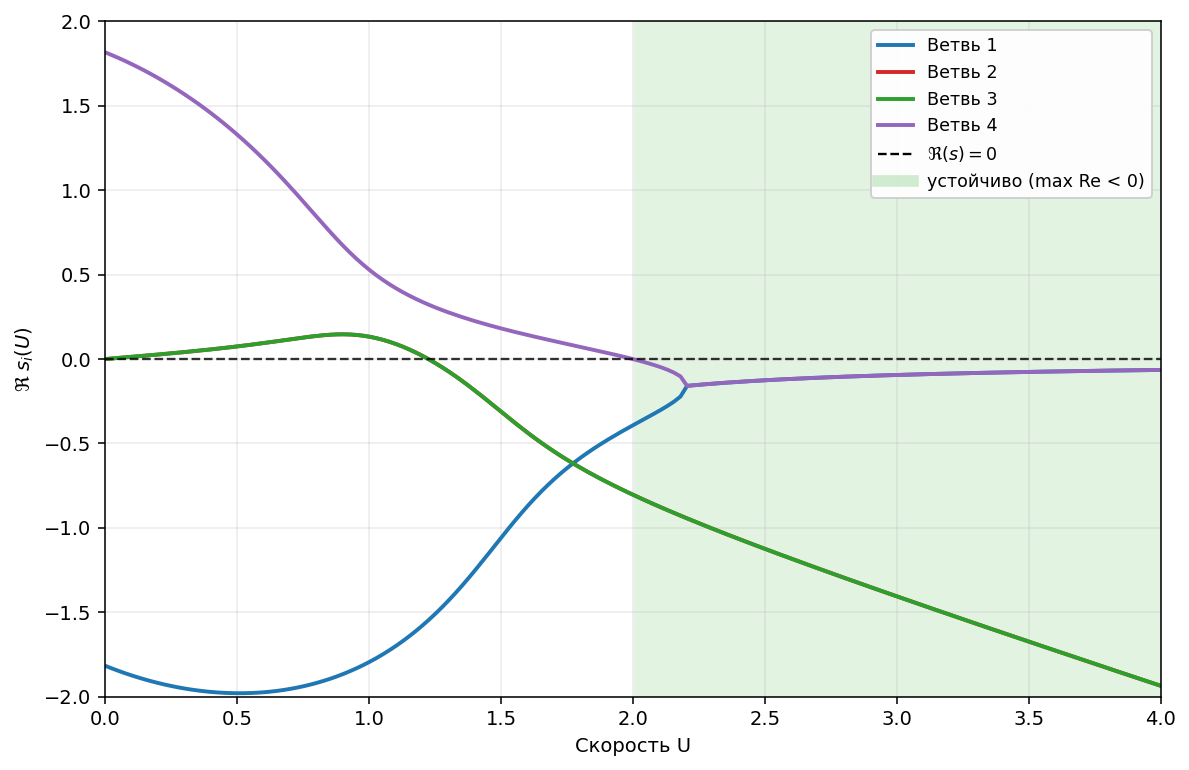

Интервалы устойчивости по U (прибл.): [2.005, 10.000]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# ---- Параметры и модель ------------------------------------------------------
m       = globals().get('m', 1.0)
J       = globals().get('J', 0.1)
K       = globals().get('K', 1.0)
k_b     = globals().get('k_b', 0.5)
k_theta = globals().get('k_theta', 2.0)

# Берём вашу функцию, иначе фолбэк
if 'A_ulalb' not in globals():
    def A_ulalb(U, l_a, l_b, m=m, J=J, K=K, k_b=k_b, k_theta=k_theta):
        return np.array([
            [0.0,         1.0,                                   0.0,                                   0.0],
            [k_b/m,     - K*U/m,               (k_b*l_b + K*U*U)/m,                                   0.0],
            [0.0,         0.0,                                   0.0,                                   1.0],
            [k_b*l_b/J, - (l_a*K*U)/J, (-k_theta + (l_b*l_b)*k_b + l_a*K*U*U)/J,                       0.0]
        ], dtype=float)

# Фиксированные геом. параметры
l_a0 = globals().get('l_a_fixed', -2.5)
l_b0 = globals().get('l_b', -3.0)

# Диапазон скоростей
U_min = 0.0
U_max = 10.0
nU    = 400
U_grid = np.linspace(U_min, U_max, nU)

# ---- Спектры на сетке по U ---------------------------------------------------
eigvals_all = np.zeros((nU, 4), dtype=complex)
for i, U in enumerate(U_grid):
    eigvals_all[i, :] = np.linalg.eigvals(A_ulalb(U, l_a0, l_b0))

# ---- Трекинг ветвей по непрерывности ----------------------------------------
branches = np.zeros_like(eigvals_all)  # (nU, 4)
# начальная сортировка по Re, затем по Im
idx0 = np.lexsort((np.imag(eigvals_all[0]), np.real(eigvals_all[0])))
branches[0] = eigvals_all[0, idx0]

for i in range(1, nU):
    prev = branches[i-1]
    curr = eigvals_all[i].copy()
    used = np.zeros(4, dtype=bool)
    for b in range(4):
        d = np.abs(curr - prev[b])
        d[used] = np.inf
        j = np.argmin(d)
        branches[i, b] = curr[j]
        used[j] = True

# ---- Поиск зон устойчивости (макс. Re < 0) ----------------------------------
max_real = np.max(np.real(branches), axis=1)
stable_mask = max_real < 0.0

# Разобьём на непрерывные стабильные сегменты (для подкраски фона)
segments = []
idx = np.where(stable_mask)[0]
if idx.size:
    start = idx[0]; prev = idx[0]
    for k in idx[1:]:
        if k == prev + 1:
            prev = k
        else:
            segments.append((start, prev)); start = k; prev = k
    segments.append((start, prev))

# ---- Визуализация ------------------------------------------------------------
fig, ax = plt.subplots(figsize=(8.6, 5.6), dpi=140)

# Зелёные полосы там, где система устойчива (max Re < 0)
for a, b in segments:
    ax.axvspan(U_grid[a], U_grid[b], color='#8fd18f', alpha=0.25, lw=0)

# Линии для 4 ветвей: Re(s_i(U))
colors = ['#1f77b4', '#d62728', '#2ca02c', '#9467bd']
for b in range(4):
    ax.plot(U_grid, np.real(branches[:, b]), lw=2.0, color=colors[b])

# Линия нуля
ax.axhline(0.0, color='k', lw=1.2, ls='--', alpha=0.8)

ax.set_xlabel('Скорость U')
ax.set_ylabel(r'$\Re\;s_i(U)$')
# ax.set_title(r'Вещественные части собственных значений $s_i(U)$'
#              f'\n$r_L={l_a0}$, $r_A={l_b0}$')

# Легенда
legend_elems = [Line2D([0],[0], color=colors[i], lw=2.0, label=f'Ветвь {i+1}') for i in range(4)]
legend_elems += [
    Line2D([0],[0], color='k', lw=1.2, ls='--', label=r'$\Re(s)=0$'),
    Line2D([0],[0], color='#8fd18f', lw=6, alpha=0.4, label='устойчиво (max Re < 0)')
]
ax.legend(handles=legend_elems, loc='best', fontsize=9, framealpha=0.9)

# Красивые пределы по оси Y с запасом
ymax = np.max(np.abs(np.real(branches))) if branches.size else 1.0
pad = 0.08
ax.set_ylim(-2, 2)
ax.set_xlim(U_min, 4)
ax.grid(True, alpha=0.25)

plt.tight_layout()
# plt.savefig('real_parts_vs_U.png', dpi=200, bbox_inches='tight')
plt.show()

# --- Отчёт по интервалам устойчивости ---
if segments:
    intervals = '; '.join(f'[{U_grid[a]:.3f}, {U_grid[b]:.3f}]' for a,b in segments)
    print('Интервалы устойчивости по U (прибл.):', intervals)
else:
    print('В заданном диапазоне U устойчивых интервалов не найдено.')


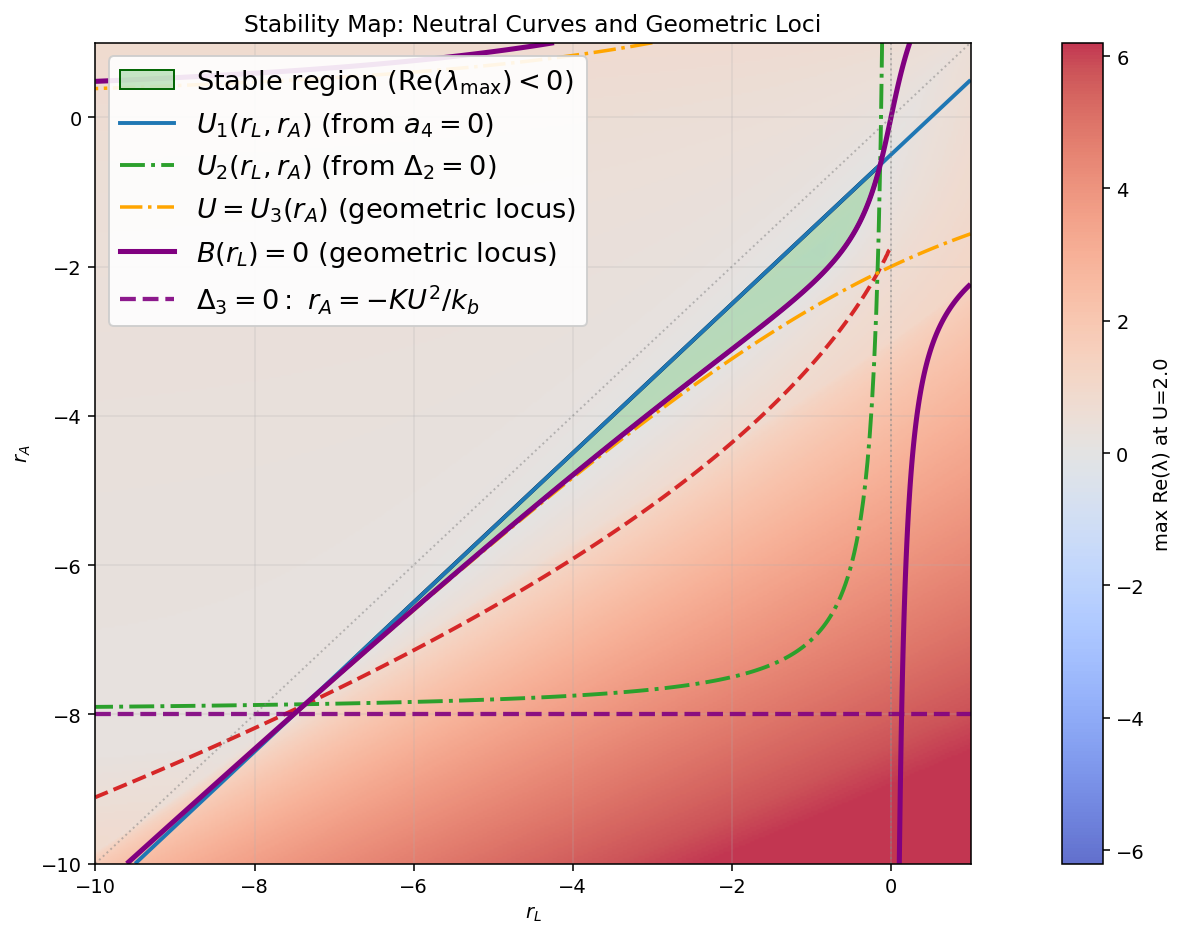

Display settings:
  Legend: ON
  Line labels: OFF
  Legend font size: 14


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

# --- DISPLAY SETTINGS ---
SHOW_LEGEND = True        # Show legend
SHOW_ANNOTATIONS = False   # Show labels on lines
LEGEND_FONTSIZE = 14      # Font size for legend (doubled from original 8)

# --- Fixed velocities ---
U_fixed_map_1     = 2.0   # for max Re(λ) heat map
U_level_analytic  = 2.0   # for U1,U2,U3 levels and curves at fixed U

# --- Model parameters (fallbacks) ---
m       = globals().get('m', 1.0)
J       = globals().get('J', 0.1)
K       = globals().get('K', 1.0)
k_b     = globals().get('k_b', 0.5)
k_theta = globals().get('k_theta', 2.0)

# --- Matrix A(U, r_L, r_A) (first-order form) ---
def A_ulalb(U, r_L, r_A, m=m, J=J, K=K, k_b=k_b, k_theta=k_theta):
    return np.array([
        [0.0,         1.0,                                   0.0,                                   0.0],
        [k_b/m,     - K*U/m,               (k_b*r_A + K*U*U)/m,                                   0.0],
        [0.0,         0.0,                                   0.0,                                   1.0],
        [k_b*r_A/J, - (r_L*K*U)/J, (-k_theta + (r_A*r_A)*k_b + r_L*K*U*U)/J,                       0.0]
    ], dtype=float)

# --- Ranges and grids for (r_L, r_A) ---
r_L_min_map, r_L_max_map = -10.0,  1.0
r_A_min_map, r_A_max_map = -10.0,  1.0
nRL_map, nRA_map       = 400, 400

r_L_min_an, r_L_max_an   = -10.0,   0.0
r_A_min_an, r_A_max_an   = -10.0,   0.0
nRL_an, nRA_an         = 400, 400

r_L_min = min(r_L_min_map, r_L_min_an)
r_L_max = max(r_L_max_map, r_L_max_an)
r_A_min = min(r_A_min_map, r_A_min_an)
r_A_max = max(r_A_max_map, r_A_max_an)

nRL_plot, nRA_plot = max(nRL_map, nRL_an), max(nRA_map, nRA_an)

RL_plot, RA_plot = np.meshgrid(
    np.linspace(r_L_min, r_L_max, nRL_plot),
    np.linspace(r_A_min, r_A_max, nRA_plot)
)

# --- 1) max Re(λ) map at U_fixed_map_1 ---
max_real_map = np.empty_like(RL_plot)
for i in range(nRA_plot):
    for j in range(nRL_plot):
        eig = np.linalg.eigvals(A_ulalb(U_fixed_map_1, RL_plot[i, j], RA_plot[i, j]))
        max_real_map[i, j] = np.max(np.real(eig))

# --- 2) Full analytical conditions on grid (all Routh-Hurwitz minors) ---
def ai_D_all(U, r_L, r_A):
    # Coefficients of monic p(s) = s^4 + a1 s^3 + a2 s^2 + a3 s + a4
    a1 = K*U/m
    a2 = -k_b/m - (k_b*r_A**2)/J - (K*U*U*r_L)/J + k_theta/J
    a3 = (K*U)/(J*m) * (k_theta - k_b*r_A**2 + k_b*r_L*r_A)
    a4 = (k_b/(J*m)) * (K*U*U*(r_L - r_A) - k_theta)
    # Minors
    D2 = a1*a2 - a3
    B  = (r_L - r_A)*(J*k_b + k_b*r_L*r_A*m) + k_theta*r_L*m
    D3 = -(K*K*U*U)/(J*J*m*m*m) * (K*U*U + k_b*r_A) * B
    return a1, a2, a3, a4, D2, D3, B

a1, a2, a3, a4, D2, D3, B = ai_D_all(U_fixed_map_1, RL_plot, RA_plot)

# Numerical cushion from zeros (noise reduction for contouring)
eps = 1e-12

# Full stability mask (all conditions simultaneously)
stable_mask_full = (a1 > eps) & (a2 > eps) & (a3 > eps) & (a4 > eps) & (D2 > eps) & (D3 > eps)

# --- 3) "Classical" curves U1,U2,U3 for level U_level_analytic ---
den1 = K * (RL_plot - RA_plot)
U1 = np.full_like(RL_plot, np.nan, dtype=float)
mask1 = (den1 > 0) & (k_theta > 0)
U1[mask1] = np.sqrt(k_theta / den1[mask1])                                 # a4=0

num2 = (J * k_b) + m * (k_b * RA_plot**2 - k_theta)
den2 = -m * K * RL_plot
U2 = np.full_like(RL_plot, np.nan, dtype=float)
mask2 = (num2 > 0) & (den2 > 0)
U2[mask2] = np.sqrt(num2[mask2] / den2[mask2])                              # a2=0

num3 = k_b * (J + m * RL_plot * RA_plot)
den3 = -m * K * RL_plot
U3 = np.full_like(RL_plot, np.nan, dtype=float)
mask3 = (num3 > 0) & (den3 > 0)
U3[mask3] = np.sqrt(num3[mask3] / den3[mask3])                              # Δ2=0

# --- 4) Visualization ---
fig, ax = plt.subplots(figsize=(9, 6.8), dpi=140)

# Background: max Re(λ) map at U_fixed_map_1
lo, hi = np.percentile(max_real_map, [2, 98])
vmax = max(abs(lo), abs(hi))
norm = TwoSlopeNorm(vmin=-vmax, vcenter=0.0, vmax=vmax)

im = ax.imshow(
    max_real_map, extent=[r_L_min, r_L_max, r_A_min, r_A_max],
    origin='lower', aspect='auto', cmap='coolwarm', norm=norm, alpha=0.80
)
cbar = plt.colorbar(im, ax=ax, pad=0.08)
cbar.set_label(f'max Re(λ) at U={U_fixed_map_1:.1f}')

# Full green stability mask (all conditions)
neg_full = np.ma.masked_where(~stable_mask_full, stable_mask_full.astype(float))
ax.contourf(RL_plot, RA_plot, neg_full, levels=[0.5, 1.5], colors=['#8fd18f40'], alpha=0.5)

# Contour Re(λ_max)=0
cs_map = ax.contour(RL_plot, RA_plot, max_real_map, levels=[0.0], colors='k', linewidths=2)

# --- Level lines U1,U2,U3 (as references) ---
levels = [U_level_analytic]
if np.isfinite(U1).any():
    cs1 = ax.contour(RL_plot, RA_plot, U1, levels=levels, colors='#1f77b4', linewidths=2.0)
if np.isfinite(U2).any():
    cs2 = ax.contour(RL_plot, RA_plot, U2, levels=levels, colors='#d62728', linewidths=2.0, linestyles='--')
if np.isfinite(U3).any():
    cs3 = ax.contour(RL_plot, RA_plot, U3, levels=levels, colors='#2ca02c', linewidths=2.0, linestyles='-.')

# --- Critical curves at fixed U ---
# 1) a3 = 0 (U-independent geometric curve)
csA3 = ax.contour(RL_plot, RA_plot, (k_theta - k_b*RA_plot**2 + k_b*RL_plot*RA_plot),
                  levels=[0.0], colors='orange', linestyles='-.', linewidths=1.8)

# 2) Δ3 = 0: two branches
# 2a) Velocity horizontal: r_A = -K U^2 / k_b
r_A_line = -K*U_level_analytic**2 / k_b
ax.axhline(r_A_line, color='purple', ls='--', lw=2.2, alpha=0.9)

# 2b) Geometric curve B(r_L)=0 — MAIN FOCUS
csB = ax.contour(RL_plot, RA_plot, B, levels=[0.0], colors='purple', linestyles='-', linewidths=2.6)

# --- Additional guides ---
ax.plot([r_L_min, r_L_max], [r_L_min, r_L_max], color='gray', lw=1, ls=':', alpha=0.5)
ax.axvline(0.0, color='gray', lw=1, ls=':', alpha=0.5)

# --- LABELS ON LINES (if enabled) ---
if SHOW_ANNOTATIONS:
    # Labels for analytical curves
    ax.text(-5, -8.5, r'$a_3=0$', fontsize=10, color='orange', rotation=0,
            bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8))

    ax.text(-1.5, r_A_line+0.3, r'$\Delta_3=0:\ r_A=-KU^2/k_b$', fontsize=9, color='purple',
            bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8))

    ax.text(-8, -2, r'$\Delta_3=0:\ B(r_L)=0$', fontsize=9, color='purple', rotation=0,
            bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8))

    ax.text(-6, -6.5, r'$r_L=r_A$', fontsize=9, color='gray', rotation=45,
            bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8))

    ax.text(0.2, -5, r'$r_L=0$', fontsize=9, color='gray', rotation=0,
            bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8))

    # Label for stable region
    if np.any(stable_mask_full):
        stable_points = np.where(stable_mask_full)
        if len(stable_points[0]) > 0:
            center_r_L = RL_plot[stable_points[0][0], stable_points[1][0]]
            center_r_A = RA_plot[stable_points[0][0], stable_points[1][0]]
            ax.text(center_r_L, center_r_A, 'Stable\nregion', fontsize=10,
                    color='darkgreen', weight='bold', ha='center', va='center',
                    bbox=dict(boxstyle="round,pad=0.5", facecolor='#8fd18f80', edgecolor='darkgreen'))

# --- Formatting ---
ax.set_xlim(r_L_min, r_L_max)
ax.set_ylim(r_A_min, r_A_max)
ax.set_xlabel(r'$r_L$')
ax.set_ylabel(r'$r_A$')
ax.set_title('Stability Map: Neutral Curves and Geometric Loci')
ax.grid(True, alpha=0.25)

# --- LEGEND (if enabled) ---
if SHOW_LEGEND:
    # Create custom legend elements
    legend_elements = [
        Patch(facecolor='#8fd18f80', edgecolor='darkgreen', label=r'Stable region ($\mathrm{Re}(\lambda_{\mathrm{max}})<0$)'),
        Line2D([0], [0], color='#1f77b4', linewidth=2.0, label=r'$U_1(r_L,r_A)$ (from $a_4=0$)'),
        Line2D([0], [0], color='#2ca02c', linestyle='-.', linewidth=2.0,
               label=r'$U_2(r_L,r_A)$ (from $\Delta_2=0$)'),
        Line2D([0], [0], color='orange', linestyle='-.', linewidth=1.8,
               label=r'$U = U_3(r_A)$ (geometric locus)'),
        Line2D([0], [0], color='purple', linestyle='-', linewidth=2.6,
               label=r'$B(r_L) = 0$ (geometric locus)'),
        Line2D([0], [0], color='purple', linestyle='--', linewidth=2.2, alpha=0.9,
               label=r'$\Delta_3=0:\ r_A=-KU^2/k_b$')
    ]

    # Add legend with custom elements and increased font size
    ax.legend(handles=legend_elements, loc='upper left', fontsize=LEGEND_FONTSIZE, framealpha=0.9)

plt.tight_layout()
plt.show()

# --- DISPLAY SETTINGS INFO ---
print(f"Display settings:")
print(f"  Legend: {'ON' if SHOW_LEGEND else 'OFF'}")
print(f"  Line labels: {'ON' if SHOW_ANNOTATIONS else 'OFF'}")
print(f"  Legend font size: {LEGEND_FONTSIZE}")

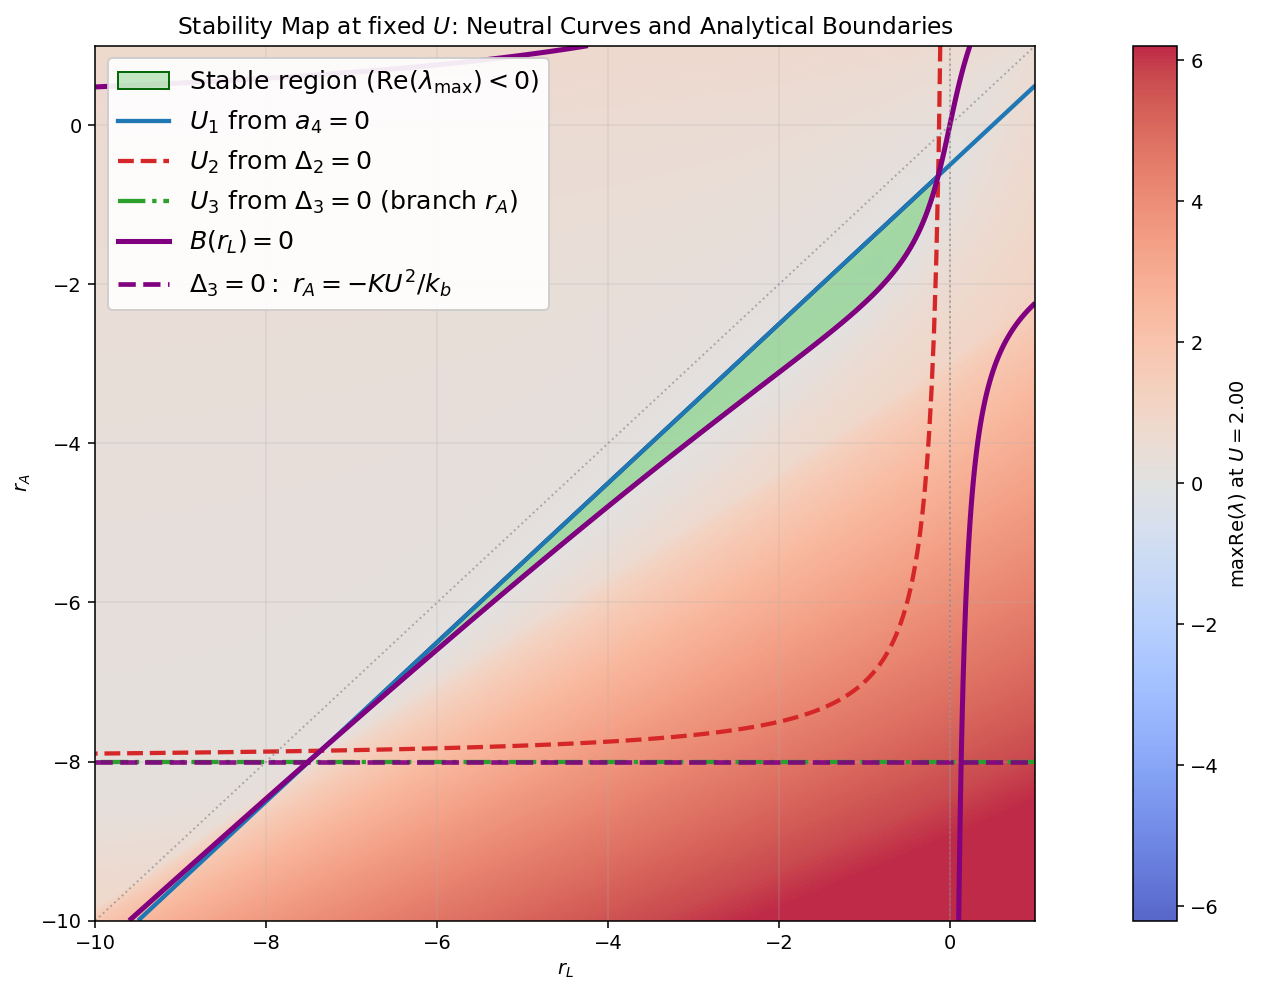

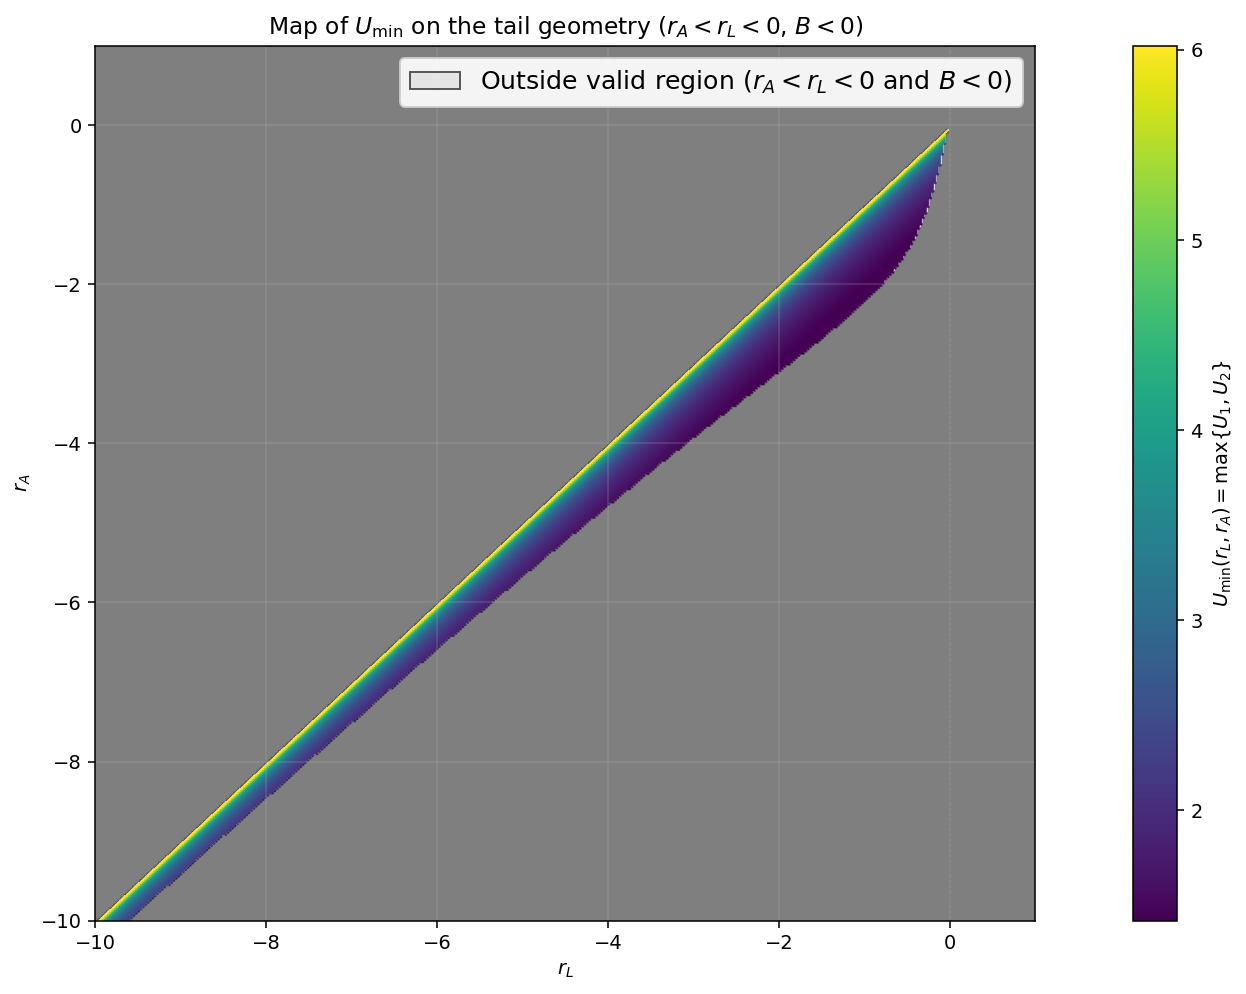

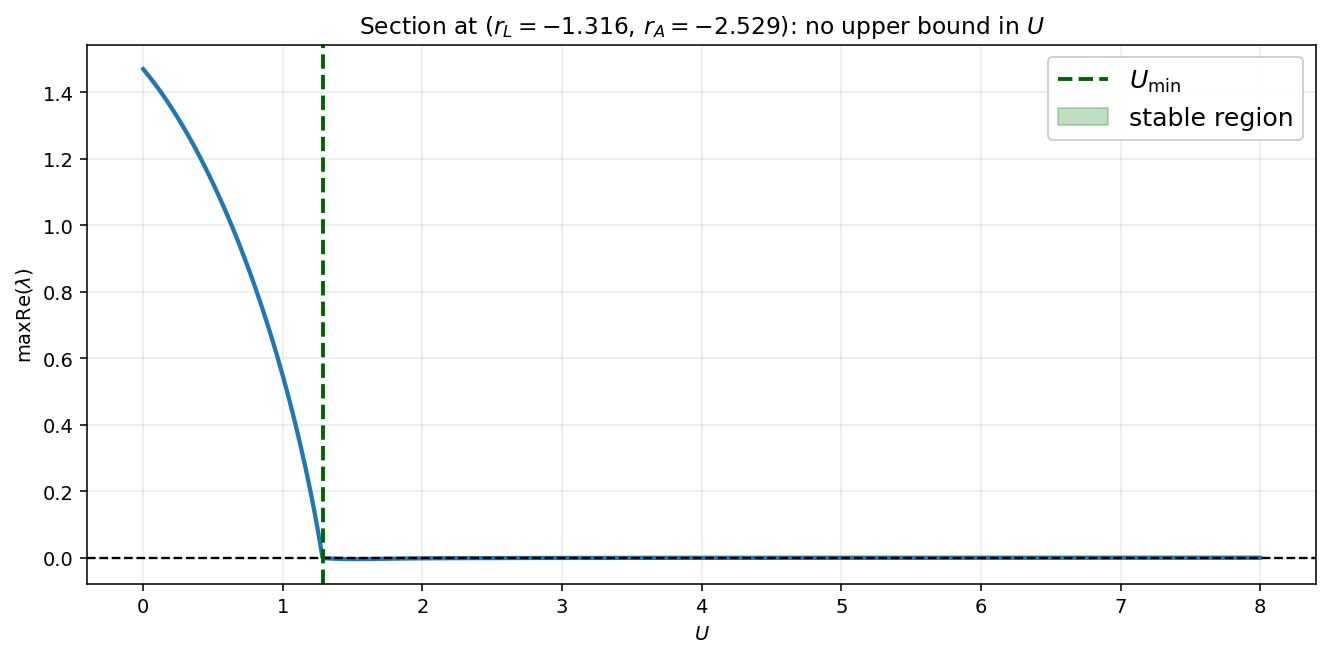

Figures generated:
  1) Stability map at fixed U with neutral curves and analytical boundaries.
  2) U_min map on the valid geometry branch (tail: r_A<r_L<0, B<0).
  3) 1D section max Re(λ) vs U at the best geometry point showing no upper bound.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

# ------------------ DISPLAY SETTINGS ------------------
SHOW_LEGEND        = True
SHOW_ANNOTATIONS   = False
LEGEND_FONTSIZE    = 13
SAVE_PNG           = False   # при True сохранит рисунки в файлы .png

# ------------------ MODEL PARAMETERS ------------------
# Можно переопределить извне; иначе используем значения по умолчанию:
m       = globals().get('m', 1.0)
J       = globals().get('J', 0.10)
K       = globals().get('K', 1.0)
k_b     = globals().get('k_b', 0.5)
k_theta = globals().get('k_theta', 2.0)

# ------------------ FIXED VELOCITIES ------------------
U_fixed_map   = 2.0    # карта Re(λ_max) при фикс. U
U_level       = 2.0    # уровень для контуров U1, U2, U3
U_scan_max    = 8.0    # макс. скорость для 1D-сечения Re(λ_max)(U)
U_scan_pts    = 400

# ------------------ STATE MATRIX A(U, rL, rA) ------------------
def A_ulalb(U, r_L, r_A, m=m, J=J, K=K, k_b=k_b, k_theta=k_theta):
    return np.array([
        [0.0,         1.0,                                   0.0,                                   0.0],
        [k_b/m,     - K*U/m,               (k_b*r_A + K*U*U)/m,                                   0.0],
        [0.0,         0.0,                                   0.0,                                   1.0],
        [k_b*r_A/J, - (r_L*K*U)/J, (-k_theta + (r_A*r_A)*k_b + r_L*K*U*U)/J,                       0.0]
    ], dtype=float)

# ------------------ RANGES FOR rL & rA ------------------
# Большой охват + «рабочий» хвостовой квадрант r_A<r_L<0
r_L_min, r_L_max = -10.0,  1.0
r_A_min, r_A_max = -10.0,  1.0
nRL, nRA         = 400, 400

rL, rA = np.meshgrid(
    np.linspace(r_L_min, r_L_max, nRL),
    np.linspace(r_A_min, r_A_max, nRA)
)

# ------------------ HELPER: EIG MAX REAL ------------------
def max_real_eig(U, r_L_grid, r_A_grid):
    out = np.empty_like(r_L_grid, dtype=float)
    for i in range(r_L_grid.shape[0]):
        for j in range(r_L_grid.shape[1]):
            eig = np.linalg.eigvals(A_ulalb(U, r_L_grid[i, j], r_A_grid[i, j]))
            out[i, j] = np.max(np.real(eig))
    return out

# ------------------ ROUTH–HURWITZ COEFFICIENTS & MINORS ------------------
def ai_D_all(U, r_L, r_A):
    """
    Возвращает коэффициенты многочлена p(s)=s^4+a1 s^3+a2 s^2+a3 s + a4
    и миноры RH: Δ2=a1 a2 - a3, Δ3 (факторизованная форма), а также B(r_L).
    """
    a1 = K*U/m
    a2 = -k_b/m - (k_b*r_A**2)/J - (K*U*U*r_L)/J + k_theta/J
    a3 = (K*U)/(J*m) * (k_theta - k_b*r_A**2 + k_b*r_L*r_A)
    a4 = (k_b/(J*m)) * (K*U*U*(r_L - r_A) - k_theta)
    D2 = a1*a2 - a3
    B  = (r_L - r_A)*(J*k_b + k_b*r_L*r_A*m) + k_theta*r_L*m
    D3 = -(K*K*U*U)/(J*J*m*m*m) * (K*U*U + k_b*r_A) * B
    return a1, a2, a3, a4, D2, D3, B

# ------------------ ANALYTICAL THRESHOLDS ------------------
def U1_map(r_L, r_A):
    # a4=0 -> U1^2 = k_theta / [K (r_L - r_A)], требуется r_L - r_A > 0
    den = K*(r_L - r_A)
    U = np.full_like(r_L, np.nan, dtype=float)
    mask = (den > 0) & (k_theta > 0)
    U[mask] = np.sqrt(k_theta / den[mask])
    return U

def U2_map(r_L, r_A):
    # Δ2=0 -> U2^2 = k_b (J + m r_L r_A) / (- m K r_L), требуется r_L<0 (для хвоста) и числитель>0
    num = k_b*(J + m*r_L*r_A)
    den = -m*K*r_L
    U = np.full_like(r_L, np.nan, dtype=float)
    mask = (den > 0) & (num > 0)
    U[mask] = np.sqrt(num[mask] / den[mask])
    return U

def U3_map_branch1(r_L, r_A):
    # Δ3=0 (скоростная ветка) -> K U^2 + k_b r_A = 0 -> U3^2 = -k_b r_A / K, требуется r_A<0
    U = np.full_like(r_L, np.nan, dtype=float)
    num = -k_b*r_A / K
    mask = (num > 0)
    U[mask] = np.sqrt(num[mask])
    return U

# ------------------ 1) STABILITY MAP AT FIXED U ------------------
max_real_map = max_real_eig(U_fixed_map, rL, rA)
a1, a2, a3, a4, D2, D3, B = ai_D_all(U_fixed_map, rL, rA)

eps = 1e-12
stable_mask_full = (a1 > eps) & (a2 > eps) & (a3 > eps) & (a4 > eps) & (D2 > eps) & (D3 > eps)

U1 = U1_map(rL, rA)
U2 = U2_map(rL, rA)
U3 = U3_map_branch1(rL, rA)

fig1, ax1 = plt.subplots(figsize=(9.6, 7.2), dpi=140)

lo, hi = np.percentile(max_real_map, [2, 98])
vmax = max(abs(lo), abs(hi))
norm = TwoSlopeNorm(vmin=-vmax, vcenter=0.0, vmax=vmax)

im = ax1.imshow(
    max_real_map, extent=[r_L_min, r_L_max, r_A_min, r_A_max],
    origin='lower', aspect='auto', cmap='coolwarm', norm=norm, alpha=0.85
)
cbar = plt.colorbar(im, ax=ax1, pad=0.08)
cbar.set_label(rf'$\max \mathrm{{Re}}(\lambda)$ at $U={U_fixed_map:.2f}$')


# Заливка области полной устойчивости
mask_show = np.ma.masked_where(~stable_mask_full, stable_mask_full.astype(float))
ax1.contourf(rL, rA, mask_show, levels=[0.5, 1.5], colors=['#89d38980'], alpha=0.7)

# Нейтральная кривая Re(λ_max)=0
ax1.contour(rL, rA, max_real_map, levels=[0.0], colors='k', linewidths=2.0)

# Контуры U1=U_level, U2=U_level, U3=U_level
levels = [U_level]
if np.isfinite(U1).any():
    ax1.contour(rL, rA, U1, levels=levels, colors='#1f77b4', linewidths=2.2, linestyles='-')     # a4=0
if np.isfinite(U2).any():
    ax1.contour(rL, rA, U2, levels=levels, colors='#d62728', linewidths=2.2, linestyles='--')    # Δ2=0
if np.isfinite(U3).any():
    ax1.contour(rL, rA, U3, levels=levels, colors='#2ca02c', linewidths=2.2, linestyles='-.')    # Δ3 ветка 1

# Δ3=0: ветка r_A = -K U^2 / k_b (горизонтальная линия)
r_A_line = -K*U_level**2 / k_b
ax1.axhline(r_A_line, color='purple', ls='--', lw=2.4, alpha=0.9)

# Геометрическая кривая B(r_L)=0
ax1.contour(rL, rA, B, levels=[0.0], colors='purple', linestyles='-', linewidths=2.6)

# Направляющие
ax1.plot([r_L_min, r_L_max], [r_L_min, r_L_max], color='gray', lw=1.0, ls=':', alpha=0.6)
ax1.axvline(0.0, color='gray', lw=1.0, ls=':', alpha=0.6)

ax1.set_xlim(r_L_min, r_L_max)
ax1.set_ylim(r_A_min, r_A_max)
ax1.set_xlabel(r'$r_L$')
ax1.set_ylabel(r'$r_A$')
ax1.set_title('Stability Map at fixed $U$: Neutral Curves and Analytical Boundaries')
ax1.grid(True, alpha=0.25)

if SHOW_LEGEND:
    legend_elements = [
        Patch(facecolor='#89d38980', edgecolor='darkgreen',
              label=r'Stable region ($\mathrm{Re}(\lambda_{\max})<0$)'),
        Line2D([0],[0], color='#1f77b4', lw=2.2, ls='-',  label=r'$U_1$ from $a_4=0$'),
        Line2D([0],[0], color='#d62728', lw=2.2, ls='--', label=r'$U_2$ from $\Delta_2=0$'),
        Line2D([0],[0], color='#2ca02c', lw=2.2, ls='-.', label=r'$U_3$ from $\Delta_3=0$ (branch $r_A$)'),
        Line2D([0],[0], color='purple',  lw=2.6, ls='-',  label=r'$B(r_L)=0$'),
        Line2D([0],[0], color='purple',  lw=2.4, ls='--', label=r'$\Delta_3=0:\ r_A=-KU^2/k_b$')
    ]
    ax1.legend(handles=legend_elements, loc='upper left', fontsize=LEGEND_FONTSIZE, framealpha=0.92)

plt.tight_layout()
if SAVE_PNG: plt.savefig('fig1_stability_map_fixed_U.png', dpi=220)
plt.show()

# ------------------ 2) MAP OF U_min(rL,rA) ------------------
# Геометрическая область хвоста: r_A < r_L < 0
geom_mask = (rA < rL) & (rL < 0)
# Ветка с окном устойчивости: B(r_L) < 0
B_all = B  # уже считали для U_fixed_map; B не зависит от U
branch_mask = (B_all < 0)

U1_full = U1_map(rL, rA)
U2_full = U2_map(rL, rA)

# U_min = max(U1, U2) там, где обе определены; иначе NaN
Umin = np.full_like(rL, np.nan, dtype=float)
mask_both = np.isfinite(U1_full) & np.isfinite(U2_full) & geom_mask & branch_mask
Umin[mask_both] = np.maximum(U1_full[mask_both], U2_full[mask_both])

fig2, ax2 = plt.subplots(figsize=(9.6, 7.2), dpi=140)

# Покажем только разумный диапазон Umin
if np.isfinite(Umin).any():
    vmin = np.nanpercentile(Umin, 5)
    vmax = np.nanpercentile(Umin, 95)
else:
    vmin, vmax = 0.0, 1.0

im2 = ax2.imshow(
    Umin, extent=[r_L_min, r_L_max, r_A_min, r_A_max],
    origin='lower', aspect='auto', cmap='viridis', vmin=vmin, vmax=vmax
)
cbar2 = plt.colorbar(im2, ax=ax2, pad=0.08)
cbar2.set_label(r'$U_{\min}(r_L,r_A)=\max\{U_1,U_2\}$')

# Маски для геометрии/ветки: покажем штриховку вне области
invalid = ~mask_both
ax2.contourf(rL, rA, invalid, levels=[0.5, 1.5], colors=['#00000010'], alpha=0.5)

# Для наглядности — граница r_A=r_L и ось r_L=0
ax2.plot([r_L_min, r_L_max], [r_L_min, r_L_max], color='gray', lw=1.0, ls=':', alpha=0.7)
ax2.axvline(0.0, color='gray', lw=1.0, ls=':', alpha=0.7)

ax2.set_xlim(r_L_min, r_L_max)
ax2.set_ylim(r_A_min, r_A_max)
ax2.set_xlabel(r'$r_L$')
ax2.set_ylabel(r'$r_A$')
ax2.set_title(r'Map of $U_{\min}$ on the tail geometry ($r_A<r_L<0$, $B<0$)')
ax2.grid(True, alpha=0.25)

if SHOW_LEGEND:
    legend2 = [
        Patch(facecolor='#00000010', edgecolor='#555555',
              label=r'Outside valid region ($r_A<r_L<0$ and $B<0$)'),
    ]
    ax2.legend(handles=legend2, loc='upper right', fontsize=LEGEND_FONTSIZE, framealpha=0.92)

plt.tight_layout()
if SAVE_PNG: plt.savefig('fig2_Umin_map.png', dpi=220)
plt.show()

# ------------------ 3) 1D SECTION: max Re(λ) vs U ------------------
# Выберем точку с минимальным Umin в валидной области
if np.isfinite(Umin).any():
    idx = np.nanargmin(Umin)
    i_sel, j_sel = np.unravel_index(idx, Umin.shape)
    rL_sel = rL[i_sel, j_sel]
    rA_sel = rA[i_sel, j_sel]
else:
    # fallback: «разумная» хвостовая пара
    rL_sel, rA_sel = -0.10, -0.15

U_grid = np.linspace(0.0, U_scan_max, U_scan_pts)
maxRe = np.zeros_like(U_grid)
for k, Uk in enumerate(U_grid):
    eig = np.linalg.eigvals(A_ulalb(Uk, rL_sel, rA_sel))
    maxRe[k] = np.max(np.real(eig))

# Посчитаем аналитический Umin для выбранной точки
U1_sel = U1_map(np.array([[rL_sel]]), np.array([[rA_sel]])).item()
U2_sel = U2_map(np.array([[rL_sel]]), np.array([[rA_sel]])).item()
Umin_sel = np.nan
if np.isfinite(U1_sel) and np.isfinite(U2_sel):
    Umin_sel = max(U1_sel, U2_sel)

fig3, ax3 = plt.subplots(figsize=(9.6, 4.8), dpi=140)
ax3.plot(U_grid, maxRe, lw=2.2)
ax3.axhline(0.0, color='k', ls='--', lw=1.2)

if np.isfinite(Umin_sel):
    ax3.axvline(Umin_sel, color='darkgreen', ls='--', lw=2.0, label=r'$U_{\min}$')
    # Подсветим зону устойчивости справа от Umin (нет верхней границы)
    ax3.fill_between(U_grid, maxRe, 0.0, where=(U_grid >= Umin_sel) & (maxRe <= 0.0),
                     interpolate=True, alpha=0.25, color='green', label='stable region')

ax3.set_xlabel(r'$U$')
ax3.set_ylabel(r'$\max \mathrm{Re}(\lambda)$')
ax3.set_title(r'Section at $(r_L={:.3f},\, r_A={:.3f})$: no upper bound in $U$'.format(rL_sel, rA_sel))
ax3.grid(True, alpha=0.25)
if SHOW_LEGEND: ax3.legend(loc='upper right', fontsize=LEGEND_FONTSIZE, framealpha=0.92)

plt.tight_layout()
if SAVE_PNG: plt.savefig('fig3_section_Re_vs_U.png', dpi=220)
plt.show()

print("Figures generated:")
print("  1) Stability map at fixed U with neutral curves and analytical boundaries.")
print("  2) U_min map on the valid geometry branch (tail: r_A<r_L<0, B<0).")
print("  3) 1D section max Re(λ) vs U at the best geometry point showing no upper bound.")


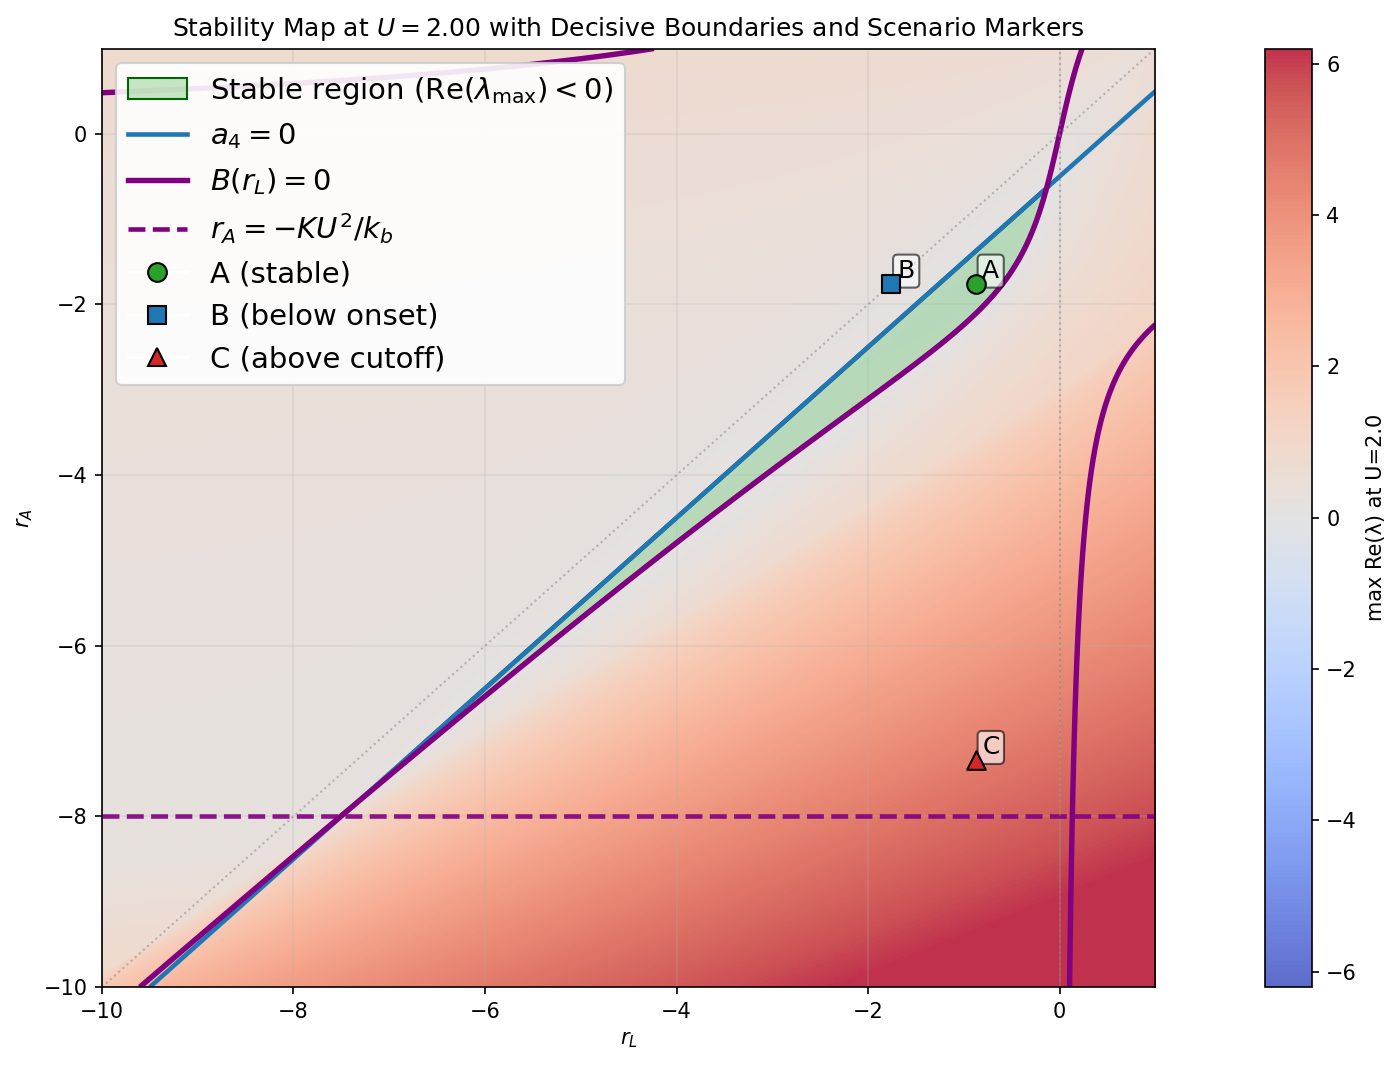

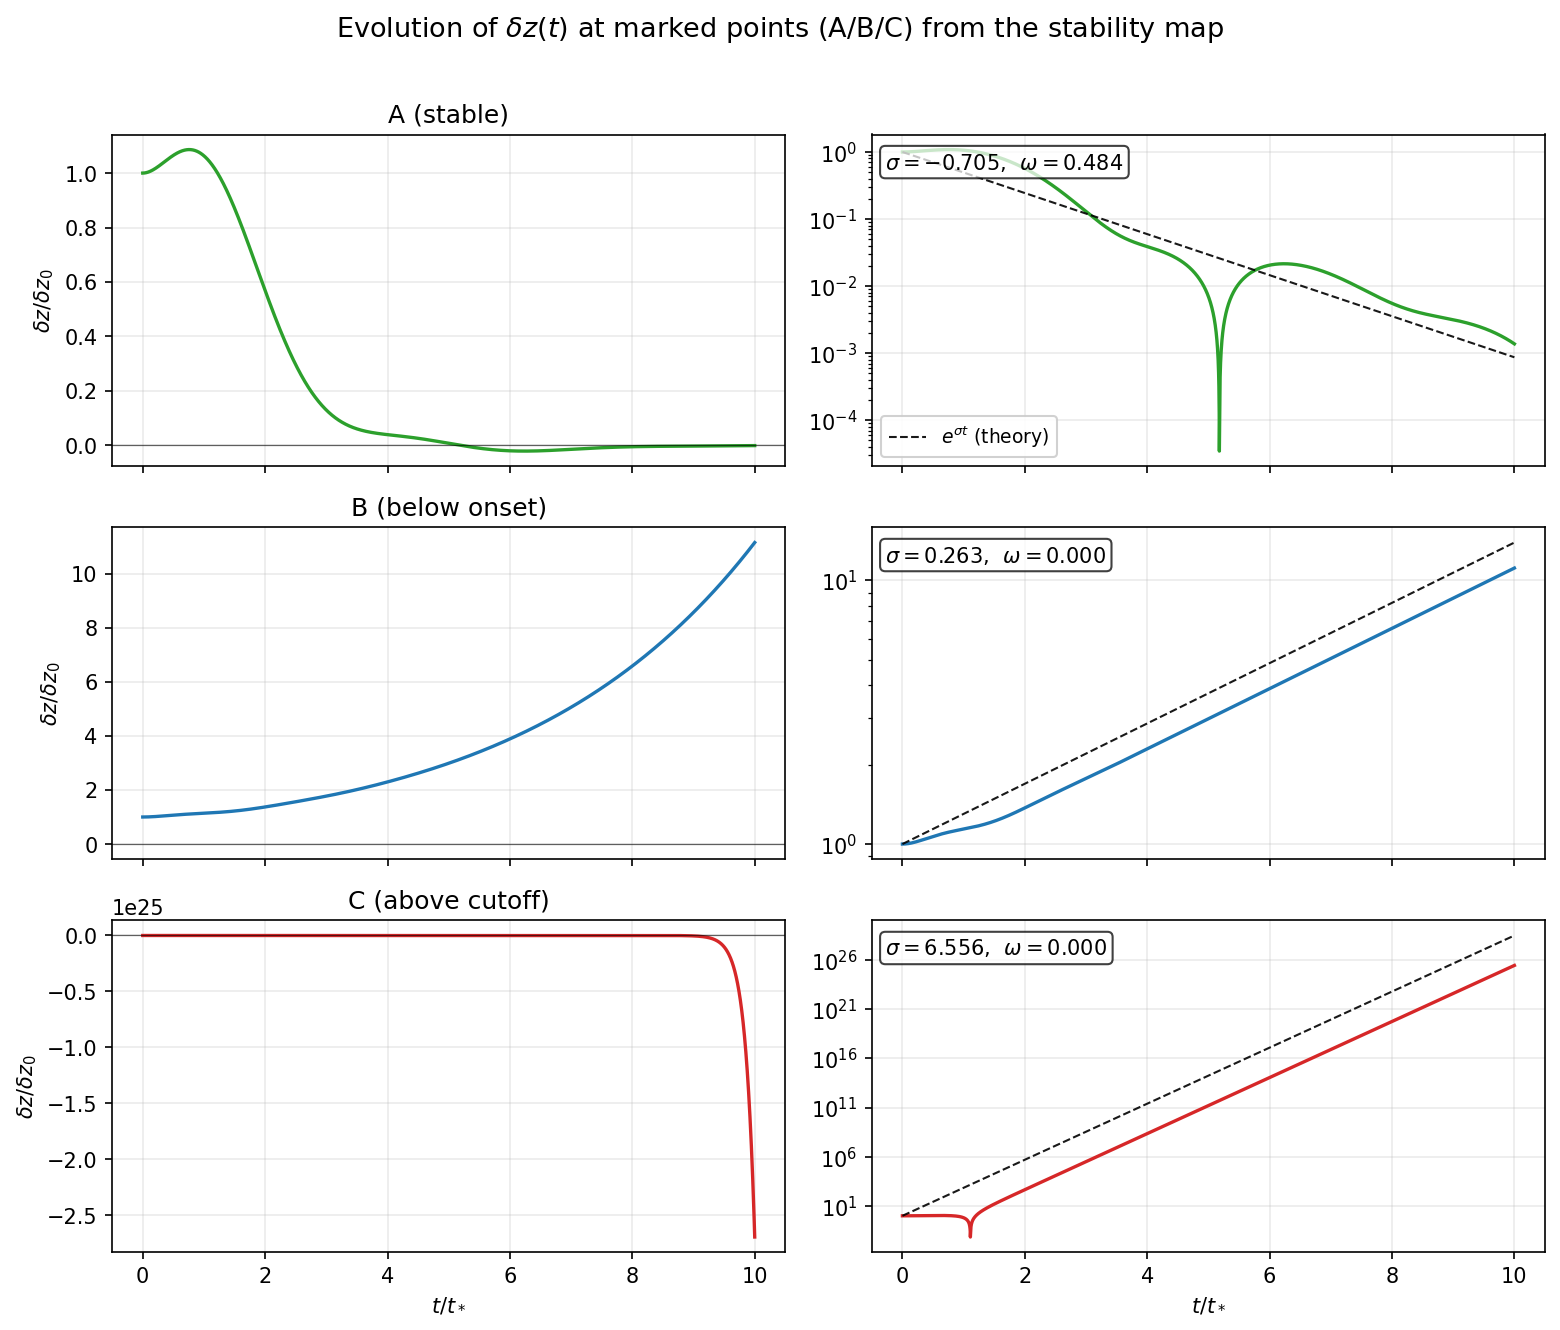

A: r_L=-0.8747, r_A=-1.7569, sigma=-0.7049, omega=0.4845
B: r_L=-1.7579, r_A=-1.7569, sigma=0.2634, omega=0.0000
C: r_L=-0.8747, r_A=-7.3400, sigma=6.5555, omega=0.0000


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

# --- DISPLAY SETTINGS ---
SHOW_LEGEND = True
SHOW_ANNOTATIONS = False
LEGEND_FONTSIZE = 14

# --- Fixed velocities ---
U_fixed_map_1     = 2.0   # for heat map
U_level_analytic  = 2.0   # for reference curves

# --- Model parameters (fallbacks) ---
m       = globals().get('m', 1.0)
J       = globals().get('J', 0.1)
K       = globals().get('K', 1.0)
k_b     = globals().get('k_b', 0.5)
k_theta = globals().get('k_theta', 2.0)

# --- Matrix A(U, r_L, r_A) (first-order form) ---
def A_ulalb(U, r_L, r_A, m=m, J=J, K=K, k_b=k_b, k_theta=k_theta):
    return np.array([
        [0.0,         1.0,                                   0.0,                                   0.0],
        [k_b/m,     - K*U/m,               (k_b*r_A + K*U*U)/m,                                   0.0],
        [0.0,         0.0,                                   0.0,                                   1.0],
        [k_b*r_A/J, - (r_L*K*U)/J, (-k_theta + (r_A*r_A)*k_b + r_L*K*U*U)/J,                       0.0]
    ], dtype=float)

# --- Ranges and grids for (r_L, r_A) ---
r_L_min_map, r_L_max_map = -10.0,  1.0
r_A_min_map, r_A_max_map = -10.0,  1.0
nRL_map, nRA_map         = 400, 400

r_L_min_an, r_L_max_an   = -10.0,   0.0
r_A_min_an, r_A_max_an   = -10.0,   0.0
nRL_an, nRA_an           = 400, 400

r_L_min = min(r_L_min_map, r_L_min_an)
r_L_max = max(r_L_max_map, r_L_max_an)
r_A_min = min(r_A_min_map, r_A_min_an)
r_A_max = max(r_A_max_map, r_A_max_an)

nRL_plot, nRA_plot = max(nRL_map, nRL_an), max(nRA_map, nRA_an)

RL_plot, RA_plot = np.meshgrid(
    np.linspace(r_L_min, r_L_max, nRL_plot),
    np.linspace(r_A_min, r_A_max, nRA_plot)
)

# --- 1) max Re(λ) map at U_fixed_map_1 ---
max_real_map = np.empty_like(RL_plot)
for i in range(nRA_plot):
    for j in range(nRL_plot):
        eig = np.linalg.eigvals(A_ulalb(U_fixed_map_1, RL_plot[i, j], RA_plot[i, j]))
        max_real_map[i, j] = np.max(np.real(eig))

# --- 2) Full analytical conditions on grid (all Routh-Hurwitz minors) ---
def ai_D_all(U, r_L, r_A):
    a1 = K*U/m
    a2 = -k_b/m - (k_b*r_A**2)/J - (K*U*U*r_L)/J + k_theta/J
    a3 = (K*U)/(J*m) * (k_theta - k_b*r_A**2 + k_b*r_L*r_A)
    a4 = (k_b/(J*m)) * (K*U*U*(r_L - r_A) - k_theta)
    D2 = a1*a2 - a3
    B  = (r_L - r_A)*(J*k_b + k_b*r_L*r_A*m) + k_theta*r_L*m
    D3 = -(K*K*U*U)/(J*J*m*m*m) * (K*U*U + k_b*r_A) * B
    return a1, a2, a3, a4, D2, D3, B

a1, a2, a3, a4, D2, D3, B = ai_D_all(U_fixed_map_1, RL_plot, RA_plot)
eps = 1e-12
stable_mask_full = (a1 > eps) & (a2 > eps) & (a3 > eps) & (a4 > eps) & (D2 > eps) & (D3 > eps)

# --- 3) "Classical" reference curves U1,U2,U3 for level U_level_analytic ---
den1 = K * (RL_plot - RA_plot)
U1 = np.full_like(RL_plot, np.nan, dtype=float)
mask1 = (den1 > 0) & (k_theta > 0)
U1[mask1] = np.sqrt(k_theta / den1[mask1])                                 # a4=0

num2 = (J * k_b) + m * (k_b * RA_plot**2 - k_theta)
den2 = -m * K * RL_plot
U2 = np.full_like(RL_plot, np.nan, dtype=float)
mask2 = (num2 > 0) & (den2 > 0)
U2[mask2] = np.sqrt(num2[mask2] / den2[mask2])                              # a2=0

num3 = k_b * (J + m * RL_plot * RA_plot)
den3 = -m * K * RL_plot
U3 = np.full_like(RL_plot, np.nan, dtype=float)
mask3 = (num3 > 0) & (den3 > 0)
U3[mask3] = np.sqrt(num3[mask3] / den3[mask3])                              # Δ2=0

# --- 4) Visualization: stability map + decisive boundaries + markers ---
fig, ax = plt.subplots(figsize=(10, 7.2), dpi=150)

# Background: max Re(λ)
lo, hi = np.percentile(max_real_map, [2, 98])
vmax = max(abs(lo), abs(hi))
norm = TwoSlopeNorm(vmin=-vmax, vcenter=0.0, vmax=vmax)
im = ax.imshow(
    max_real_map, extent=[r_L_min, r_L_max, r_A_min, r_A_max],
    origin='lower', aspect='auto', cmap='coolwarm', norm=norm, alpha=0.82
)
cbar = plt.colorbar(im, ax=ax, pad=0.08)
cbar.set_label(f'max Re(λ) at U={U_fixed_map_1:.1f}')

# Full green stability mask (all conditions)
neg_full = np.ma.masked_where(~stable_mask_full, stable_mask_full.astype(float))
ax.contourf(RL_plot, RA_plot, neg_full, levels=[0.5, 1.5], colors=['#8fd18f40'], alpha=0.5)

# Contour Re(λ_max)=0
cs_map = ax.contour(RL_plot, RA_plot, max_real_map, levels=[0.0], colors='k', linewidths=2)

# Decisive boundaries:
# 1) a4=0 (blue)
cs_a4 = ax.contour(RL_plot, RA_plot, a4, levels=[0.0], colors='#1f77b4', linewidths=2.2)

# 2) Δ3 = 0: r_A = -K U^2 / k_b (purple dashed) and B(r_L)=0 (purple solid)
r_A_line = -K*U_level_analytic**2 / k_b
ax.axhline(r_A_line, color='purple', ls='--', lw=2.2, alpha=0.9)
cs_B = ax.contour(RL_plot, RA_plot, B, levels=[0.0], colors='purple', linestyles='-', linewidths=2.6)

# Guides
ax.plot([r_L_min, r_L_max], [r_L_min, r_L_max], color='gray', lw=1, ls=':', alpha=0.5)
ax.axvline(0.0, color='gray', lw=1, ls=':', alpha=0.5)

# --- 5) Auto-select three scenario points (A: stable, B: below onset, C: above cutoff) ---
rngL = r_L_max - r_L_min
rngA = r_A_max - r_A_min

# A (stable): pick stable cell with most negative max_real (deep inside)
if np.any(stable_mask_full):
    ids = np.where(stable_mask_full)
    kmin = np.argmin(max_real_map[ids])
    iA, jA = ids[0][kmin], ids[1][kmin]
    A_point = (RL_plot[iA, jA], RA_plot[iA, jA])
else:
    A_point = (-3.0, -4.0)  # fallback

# Helper to evaluate signs at a point
def eval_signs(U, rL, rA):
    a1_, a2_, a3_, a4_, D2_, D3_, B_ = ai_D_all(U, rL, rA)
    # scalar inputs -> scalars
    return float(a4_), float(D3_), float(B_), float((K*U*U + k_b*rA))

# B (below onset): move along r_L towards r_A until a4<=0
def find_below_onset(U, rL0, rA0, steps=600):
    rL = rL0
    dr = -0.6 * rngL / steps if rL0 > rA0 else -0.3 * rngL / steps
    for _ in range(steps):
        a4_, *_ = ai_D_all(U, rL, rA0)[:4]
        if a4_ <= 0:
            return (rL, rA0)
        rL += dr
    return (rA0 - 1e-3, rA0)  # last resort: just left of r_L=r_A

B_point = find_below_onset(U_fixed_map_1, *A_point)

# C (above cutoff): jump across Δ3-horizontal to the destabilizing side
a4A, D3A, BA, speed_mult_A = eval_signs(U_fixed_map_1, *A_point)
offset = 0.06 * rngA
if BA > 0:
    # To make Δ3<0, set (KU^2+k_b r_A)*B < 0 -> flip speed multiplier
    rA_C = r_A_line - offset
else:
    rA_C = r_A_line + offset
C_point = (A_point[0], rA_C)

# Draw markers on the map
colors = {'A':'#2ca02c', 'B':'#1f77b4', 'C':'#d62728'}
markers= {'A':'o',       'B':'s',       'C':'^'}
for label, (x,y) in [('A',A_point), ('B',B_point), ('C',C_point)]:
    ax.scatter([x], [y], s=80, c=colors[label], marker=markers[label], edgecolor='k', zorder=5)
    ax.text(x+0.12*rngL/20, y+0.12*rngA/20, label, color='k', fontsize=12,
            bbox=dict(boxstyle="round,pad=0.18", facecolor='white', alpha=0.6))

# Formatting
ax.set_xlim(r_L_min, r_L_max)
ax.set_ylim(r_A_min, r_A_max)
ax.set_xlabel(r'$r_L$')
ax.set_ylabel(r'$r_A$')
ax.set_title('Stability Map at $U={:.2f}$ with Decisive Boundaries and Scenario Markers'.format(U_fixed_map_1))
ax.grid(True, alpha=0.25)

# Legend
if SHOW_LEGEND:
    legend_elements = [
        Patch(facecolor='#8fd18f80', edgecolor='darkgreen', label=r'Stable region ($\mathrm{Re}(\lambda_{\max})<0$)'),
        Line2D([0], [0], color='#1f77b4', linewidth=2.2, label=r'$a_4=0$'),
        Line2D([0], [0], color='purple', linestyle='-', linewidth=2.6, label=r'$B(r_L)=0$'),
        Line2D([0], [0], color='purple', linestyle='--', linewidth=2.2, label=r'$r_A=-KU^2/k_b$'),
        Line2D([0], [0], marker=markers['A'], color='w', markerfacecolor=colors['A'], markeredgecolor='k',
               markersize=9, label='A (stable)'),
        Line2D([0], [0], marker=markers['B'], color='w', markerfacecolor=colors['B'], markeredgecolor='k',
               markersize=9, label='B (below onset)'),
        Line2D([0], [0], marker=markers['C'], color='w', markerfacecolor=colors['C'], markeredgecolor='k',
               markersize=9, label='C (above cutoff)'),
    ]
    ax.legend(handles=legend_elements, loc='upper left', fontsize=LEGEND_FONTSIZE, framealpha=0.9)

plt.tight_layout()
plt.show()

# === 6) Time-domain evolution δz(t) for A/B/C ===

# Simple RK4 integrator for linear ODE x' = A x
def integrate_linear(A, x0, T, n_steps):
    dt = T / (n_steps - 1)
    x  = x0.copy()
    traj = np.zeros((n_steps, len(x0)))
    for k in range(n_steps):
        traj[k] = x
        k1 = A @ x
        k2 = A @ (x + 0.5*dt*k1)
        k3 = A @ (x + 0.5*dt*k2)
        k4 = A @ (x + dt*k3)
        x  = x + (dt/6.0)*(k1 + 2*k2 + 2*k3 + k4)
    return traj

def simulate_dz(U, rL, rA, z0=1e-3, T_mult=10.0, n_steps=4000):
    t_star = np.sqrt(m/k_b)
    T = T_mult * t_star
    A_mat = A_ulalb(U, rL, rA)
    x0 = np.array([z0, 0.0, 0.0, 0.0], float)
    traj = integrate_linear(A_mat, x0, T, n_steps)
    t_nd = np.linspace(0.0, T, n_steps) / t_star
    z_nd = traj[:,0] / z0
    # theoretical dominant sigma and omega (nondimensionalized by t_star)
    vals = np.linalg.eigvals(A_mat)
    lam = vals[np.argmax(np.real(vals))]
    sigma = np.real(lam) * t_star
    omega = abs(np.imag(lam)) * t_star
    return t_nd, z_nd, sigma, omega

scenarios = {
    'A': {'pt': A_point, 'color': colors['A']},
    'B': {'pt': B_point, 'color': colors['B']},
    'C': {'pt': C_point, 'color': colors['C']},
}

# Simulate
results = {}
for key, info in scenarios.items():
    rL, rA = info['pt']
    t, z, sigma, omega = simulate_dz(U_fixed_map_1, rL, rA, z0=1e-3, T_mult=10.0, n_steps=4000)
    results[key] = {'t': t, 'z': z, 'sigma': sigma, 'omega': omega}

# Build 3x2 figure: left linear, right semilog |z|
fig2, axes = plt.subplots(3, 2, figsize=(10.5, 9.0), dpi=150, sharex='col')
labels_pretty = {
    'A': 'A (stable)',
    'B': 'B (below onset)',
    'C': 'C (above cutoff)',
}

for row_idx, key in enumerate(['A','B','C']):
    col_lin = axes[row_idx, 0]
    col_log = axes[row_idx, 1]
    dat = results[key]
    color = scenarios[key]['color']
    # Linear plot
    col_lin.plot(dat['t'], dat['z'], color=color, lw=1.6)
    col_lin.axhline(0, color='k', lw=0.6, alpha=0.6)
    col_lin.set_ylabel(r'$\delta z / \delta z_0$')
    col_lin.set_title(labels_pretty[key])
    col_lin.grid(alpha=0.25)
    # Semilog |z|
    absz = np.abs(dat['z']) + 1e-14
    col_log.semilogy(dat['t'], absz, color=color, lw=1.6)
    # Overlay theoretical envelope exp(sigma t)
    env = np.exp(dat['sigma'] * dat['t'])
    col_log.semilogy(dat['t'], env, 'k--', lw=1.0, alpha=0.9, label=r'$e^{\sigma t}$ (theory)')
    col_log.grid(alpha=0.25)
    # Annotation with sigma, omega
    txt = r'$\sigma={:.3f}$, $\ \omega={:.3f}$'.format(dat['sigma'], dat['omega'])
    col_log.text(0.02, 0.95, txt, transform=col_log.transAxes, va='top', ha='left', fontsize=10,
                 bbox=dict(boxstyle="round,pad=0.25", facecolor='white', alpha=0.75))
    if row_idx == 0:
        col_log.legend(loc='lower left', fontsize=9, framealpha=0.9)

axes[-1,0].set_xlabel(r'$t/t_*$')
axes[-1,1].set_xlabel(r'$t/t_*$')
fig2.suptitle(r'Evolution of $\delta z(t)$ at marked points (A/B/C) from the stability map', fontsize=13)
plt.tight_layout(rect=[0, 0.0, 1, 0.97])
plt.show()

# Print coordinates and spectral data
for key in ['A','B','C']:
    rL, rA = scenarios[key]['pt']
    sg, om = results[key]['sigma'], results[key]['omega']
    print(f"{key}: r_L={rL:.4f}, r_A={rA:.4f}, sigma={sg:.4f}, omega={om:.4f}")


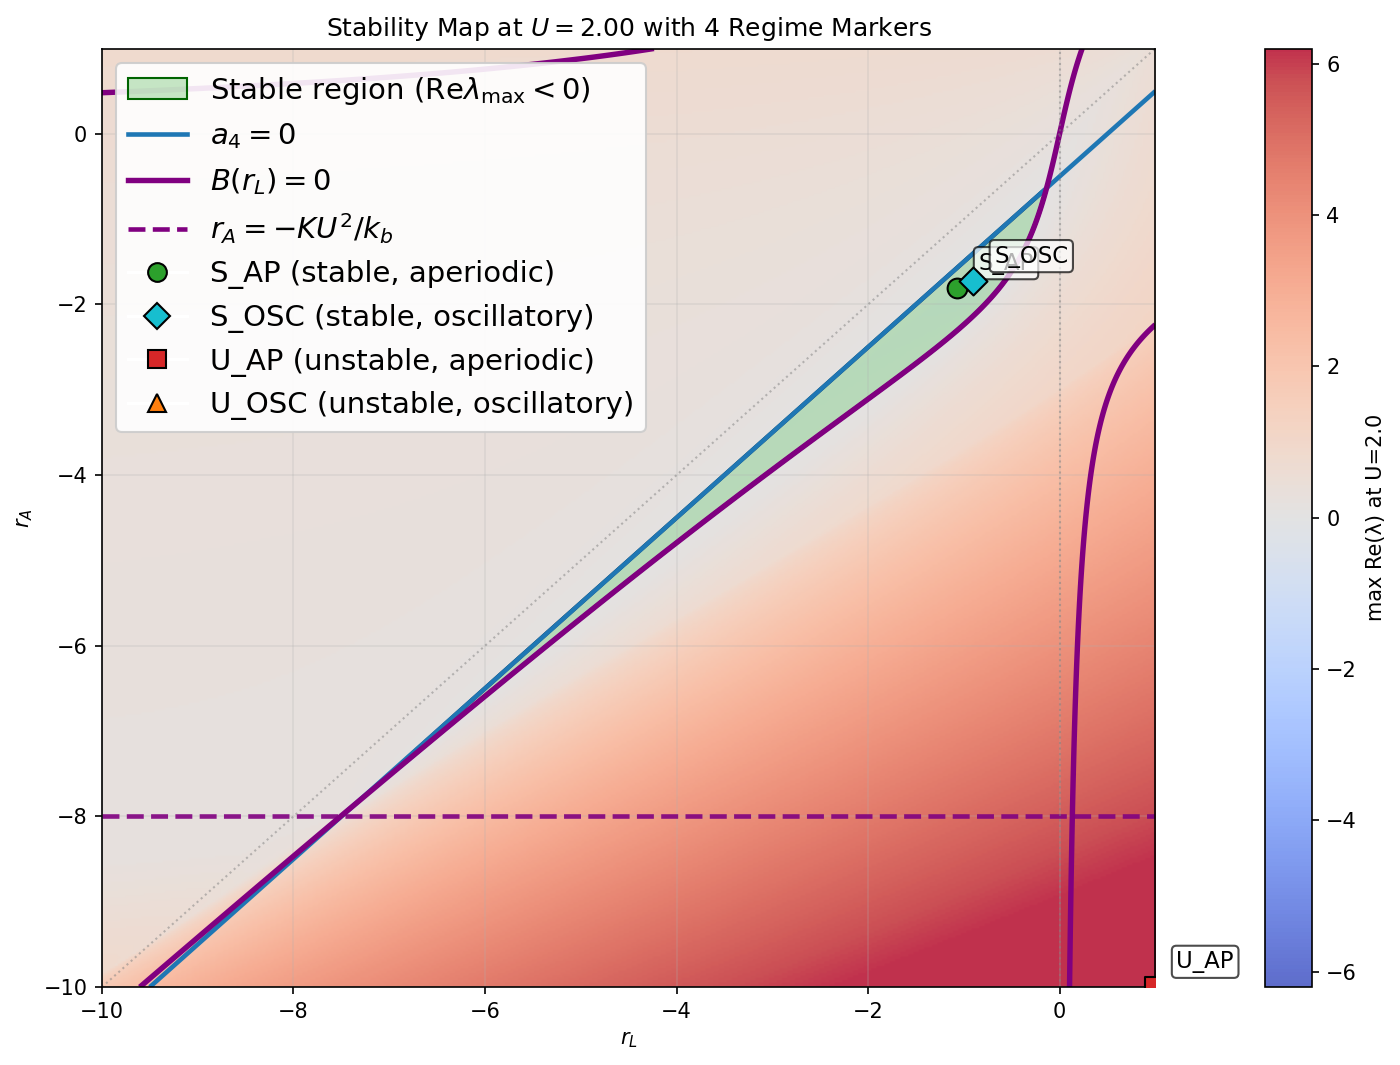

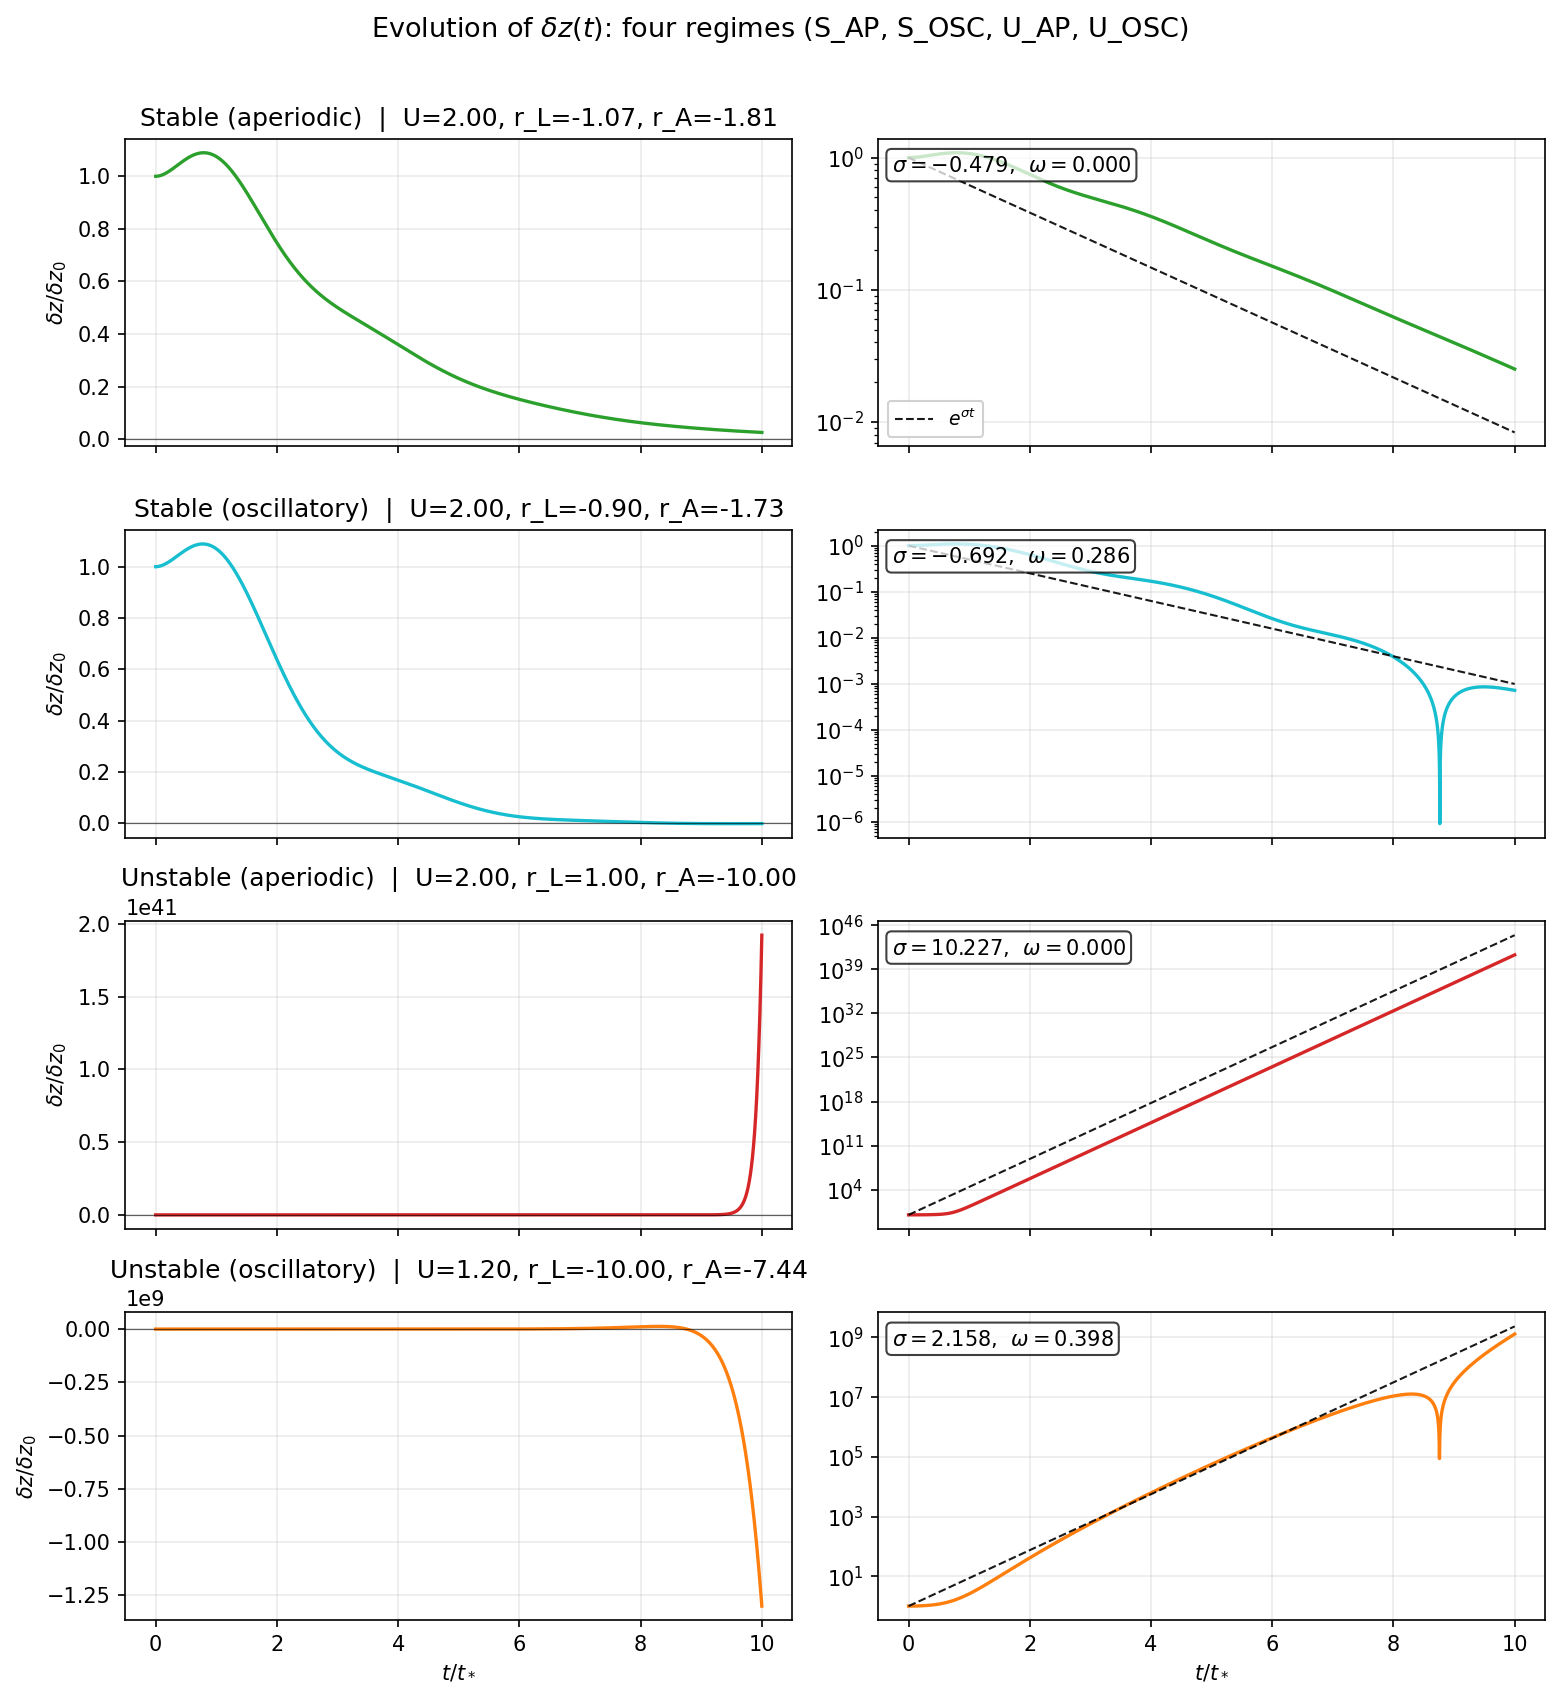

S_AP: U=2.000, r_L=-1.068, r_A=-1.812, sigma=-0.4785, omega=0.0000
S_OSC: U=2.000, r_L=-0.902, r_A=-1.729, sigma=-0.6918, omega=0.2863
U_AP: U=2.000, r_L=1.000, r_A=-10.000, sigma=10.2268, omega=0.0000
U_OSC: U=1.200, r_L=-10.000, r_A=-7.436, sigma=2.1576, omega=0.3975


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

# ---------------- DISPLAY SETTINGS ----------------
SHOW_LEGEND = True
SHOW_ANNOTATIONS = False
LEGEND_FONTSIZE = 14

# ---------------- Fixed velocities ----------------
U_fixed_map_1     = 2.0   # heat map & boundaries on the map
U_level_analytic  = 2.0   # only for reference U1,U2,U3

# ---------------- Model parameters ----------------
m       = globals().get('m', 1.0)
J       = globals().get('J', 0.1)
K       = globals().get('K', 1.0)
k_b     = globals().get('k_b', 0.5)
k_theta = globals().get('k_theta', 2.0)

# ---------------- Manual scenarios (optional) ----------------
# If any of U/rL/rA is None, the scenario will be auto-selected.
SCENARIOS_MANUAL = {
    'S_AP' : {'U': None, 'rL': None, 'rA': None},   # stable aperiodic
    'S_OSC': {'U': None, 'rL': None, 'rA': None},   # stable oscillatory
    'U_AP' : {'U': None, 'rL': None, 'rA': None},   # unstable aperiodic
    'U_OSC': {'U': None, 'rL': None, 'rA': None},   # unstable oscillatory
}
# Candidate U for auto-search (you can edit)
U_CANDIDATES = [0.7, 1.2, 2.0, 3.0]

# ---------------- System matrix ----------------
def A_ulalb(U, r_L, r_A, m=m, J=J, K=K, k_b=k_b, k_theta=k_theta):
    return np.array([
        [0.0,         1.0,                                   0.0,                                   0.0],
        [k_b/m,     - K*U/m,               (k_b*r_A + K*U*U)/m,                                   0.0],
        [0.0,         0.0,                                   0.0,                                   1.0],
        [k_b*r_A/J, - (r_L*K*U)/J, (-k_theta + (r_A*r_A)*k_b + r_L*K*U*U)/J,                       0.0]
    ], dtype=float)

# ---------------- Routh–Hurwitz pieces ----------------
def ai_D_all(U, r_L, r_A):
    a1 = K*U/m
    a2 = -k_b/m - (k_b*r_A**2)/J - (K*U*U*r_L)/J + k_theta/J
    a3 = (K*U)/(J*m) * (k_theta - k_b*r_A**2 + k_b*r_L*r_A)
    a4 = (k_b/(J*m)) * (K*U*U*(r_L - r_A) - k_theta)
    D2 = a1*a2 - a3
    B  = (r_L - r_A)*(J*k_b + k_b*r_L*r_A*m) + k_theta*r_L*m
    D3 = -(K*K*U*U)/(J*J*m*m*m) * (K*U*U + k_b*r_A) * B
    return a1, a2, a3, a4, D2, D3, B

# ---------------- Grid ----------------
r_L_min_map, r_L_max_map = -10.0,  1.0
r_A_min_map, r_A_max_map = -10.0,  1.0
nRL_map, nRA_map         = 400, 400

r_L_min_an, r_L_max_an   = -10.0, 0.0
r_A_min_an, r_A_max_an   = -10.0, 0.0
nRL_an, nRA_an           = 400, 400

r_L_min = min(r_L_min_map, r_L_min_an)
r_L_max = max(r_L_max_map, r_L_max_an)
r_A_min = min(r_A_min_map, r_A_min_an)
r_A_max = max(r_A_max_map, r_A_max_an)

nRL_plot, nRA_plot = max(nRL_map, nRL_an), max(nRA_map, nRA_an)
RL_plot, RA_plot = np.meshgrid(
    np.linspace(r_L_min, r_L_max, nRL_plot),
    np.linspace(r_A_min, r_A_max, nRA_plot)
)

# ---------------- Heat map (max Re λ) at U_fixed_map_1 ----------------
max_real_map = np.empty_like(RL_plot)
for i in range(nRA_plot):
    for j in range(nRL_plot):
        eig = np.linalg.eigvals(A_ulalb(U_fixed_map_1, RL_plot[i, j], RA_plot[i, j]))
        max_real_map[i, j] = np.max(np.real(eig))

# RH minors and geometry at U_fixed_map_1
a1, a2, a3, a4, D2, D3, B = ai_D_all(U_fixed_map_1, RL_plot, RA_plot)
eps = 1e-12
stable_mask_full = (a1 > eps) & (a2 > eps) & (a3 > eps) & (a4 > eps) & (D2 > eps) & (D3 > eps)

# ---------------- Reference U-curves (optional) ----------------
den1 = K * (RL_plot - RA_plot)
U1 = np.full_like(RL_plot, np.nan, dtype=float)
mask1 = (den1 > 0) & (k_theta > 0)
U1[mask1] = np.sqrt(k_theta / den1[mask1])                                 # a4=0

num2 = (J * k_b) + m * (k_b * RA_plot**2 - k_theta)
den2U = -m * K * RL_plot
U2 = np.full_like(RL_plot, np.nan, dtype=float)
mask2 = (num2 > 0) & (den2U > 0)
U2[mask2] = np.sqrt(num2[mask2] / den2U[mask2])                             # a2=0

num3 = k_b * (J + m * RL_plot * RA_plot)
den3U = -m * K * RL_plot
U3 = np.full_like(RL_plot, np.nan, dtype=float)
mask3 = (num3 > 0) & (den3U > 0)
U3[mask3] = np.sqrt(num3[mask3] / den3U[mask3])                             # Δ2=0

# ---------------- Figure 1: Stability map ----------------
fig, ax = plt.subplots(figsize=(10, 7.2), dpi=150)

# Heatmap
lo, hi = np.percentile(max_real_map, [2, 98])
vmax = max(abs(lo), abs(hi))
norm = TwoSlopeNorm(vmin=-vmax, vcenter=0.0, vmax=vmax)
im = ax.imshow(
    max_real_map, extent=[r_L_min, r_L_max, r_A_min, r_A_max],
    origin='lower', aspect='auto', cmap='coolwarm', norm=norm, alpha=0.82
)
cbar = plt.colorbar(im, ax=ax, pad=0.08)
cbar.set_label(f'max Re(λ) at U={U_fixed_map_1:.1f}')

# Stable region (full RH)
neg_full = np.ma.masked_where(~stable_mask_full, stable_mask_full.astype(float))
ax.contourf(RL_plot, RA_plot, neg_full, levels=[0.5, 1.5], colors=['#8fd18f40'], alpha=0.5)

# Neutral spectrum Re(λ_max)=0
ax.contour(RL_plot, RA_plot, max_real_map, levels=[0.0], colors='k', linewidths=2)

# Decisive boundaries
# a4=0 (blue)
ax.contour(RL_plot, RA_plot, a4, levels=[0.0], colors='#1f77b4', linewidths=2.2)
# Δ3=0 branches: r_A = -K U^2 / k_b and B(r_L)=0
r_A_line = -K*U_fixed_map_1**2 / k_b
ax.axhline(r_A_line, color='purple', ls='--', lw=2.2, alpha=0.9)
ax.contour(RL_plot, RA_plot, B, levels=[0.0], colors='purple', linestyles='-', linewidths=2.6)

# Guides
ax.plot([r_L_min, r_L_max], [r_L_min, r_L_max], color='gray', lw=1, ls=':', alpha=0.5)
ax.axvline(0.0, color='gray', lw=1, ls=':', alpha=0.5)

# ---------------- Auto/Manual selection of 4 regimes ----------------
def classify_regime(U, rL, rA, tol=1e-9):
    """Return ('S_AP'|'S_OSC'|'U_AP'|'U_OSC'|None), sigma_nd, omega_nd."""
    A = A_ulalb(U, rL, rA)
    vals = np.linalg.eigvals(A)
    # dominant by real part
    kmax = np.argmax(np.real(vals))
    lam = vals[kmax]
    sigma = np.real(lam) * np.sqrt(m/k_b)      # nondim by t*=sqrt(m/k_b)
    omega = abs(np.imag(lam)) * np.sqrt(m/k_b) # nondim
    if sigma < -tol:
        return ('S_OSC' if abs(np.imag(lam)) > tol else 'S_AP', sigma, omega)
    elif sigma > tol:
        return ('U_OSC' if abs(np.imag(lam)) > tol else 'U_AP', sigma, omega)
    else:
        return (None, sigma, omega)

def auto_find_scenarios():
    found = {}
    # coarse stride to speed up search
    stride = max(1, nRL_plot // 120)  # ~ up to 120x120 checks
    for U in U_CANDIDATES:
        for i in range(0, nRA_plot, stride):
            for j in range(0, nRL_plot, stride):
                rL, rA = RL_plot[i, j], RA_plot[i, j]
                label, sigma, omega = classify_regime(U, rL, rA)
                if label is None:
                    continue
                # choose best by margin: most negative sigma for stable, most positive for unstable
                if label not in found:
                    found[label] = {'U':U,'rL':rL,'rA':rA,'sigma':sigma,'omega':omega}
                else:
                    if label.startswith('S'):
                        if sigma < found[label]['sigma']:   # more negative
                            found[label] = {'U':U,'rL':rL,'rA':rA,'sigma':sigma,'omega':omega}
                    else:
                        if sigma > found[label]['sigma']:   # more positive
                            found[label] = {'U':U,'rL':rL,'rA':rA,'sigma':sigma,'omega':omega}
        # stop early if all four are found
        if all(k in found for k in ['S_AP','S_OSC','U_AP','U_OSC']):
            break
    return found

# Merge manual with auto
auto = auto_find_scenarios()
SCENARIOS = {}
for key in ['S_AP','S_OSC','U_AP','U_OSC']:
    man = SCENARIOS_MANUAL[key]
    if (man['U'] is None) or (man['rL'] is None) or (man['rA'] is None):
        if key not in auto:
            raise RuntimeError(f"Auto-search could not find scenario {key}. "
                               f"Try adjusting U_CANDIDATES or domain.")
        SCENARIOS[key] = {'U':auto[key]['U'], 'rL':auto[key]['rL'], 'rA':auto[key]['rA']}
    else:
        SCENARIOS[key] = {'U':man['U'], 'rL':man['rL'], 'rA':man['rA']}

# Colors/markers per regime
reg_colors  = {'S_AP':'#2ca02c', 'S_OSC':'#17becf', 'U_AP':'#d62728', 'U_OSC':'#ff7f0e'}
reg_markers = {'S_AP':'o',       'S_OSC':'D',       'U_AP':'s',       'U_OSC':'^'}

# Put markers on the map only if scenario U equals map U
for key, sc in SCENARIOS.items():
    if abs(sc['U'] - U_fixed_map_1) < 1e-12:
        x, y = sc['rL'], sc['rA']
        ax.scatter([x],[y], s=90, c=reg_colors[key], marker=reg_markers[key], edgecolor='k', zorder=6)
        ax.text(x+0.02*(r_L_max-r_L_min), y+0.02*(r_A_max-r_A_min), key, fontsize=11,
                bbox=dict(boxstyle="round,pad=0.2", facecolor='white', alpha=0.7))

# Formatting & legend
ax.set_xlim(r_L_min, r_L_max)
ax.set_ylim(r_A_min, r_A_max)
ax.set_xlabel(r'$r_L$')
ax.set_ylabel(r'$r_A$')
ax.set_title('Stability Map at $U={:.2f}$ with 4 Regime Markers'.format(U_fixed_map_1))
ax.grid(True, alpha=0.25)

if SHOW_LEGEND:
    legend_elements = [
        Patch(facecolor='#8fd18f80', edgecolor='darkgreen', label=r'Stable region ($\mathrm{Re}\lambda_{\max}<0$)'),
        Line2D([0],[0], color='#1f77b4', linewidth=2.2, label=r'$a_4=0$'),
        Line2D([0],[0], color='purple', linestyle='-',  linewidth=2.6, label=r'$B(r_L)=0$'),
        Line2D([0],[0], color='purple', linestyle='--', linewidth=2.2, label=r'$r_A=-KU^2/k_b$'),
        Line2D([0],[0], marker=reg_markers['S_AP'], color='w', markerfacecolor=reg_colors['S_AP'],
               markeredgecolor='k', markersize=9, label='S_AP (stable, aperiodic)'),
        Line2D([0],[0], marker=reg_markers['S_OSC'], color='w', markerfacecolor=reg_colors['S_OSC'],
               markeredgecolor='k', markersize=9, label='S_OSC (stable, oscillatory)'),
        Line2D([0],[0], marker=reg_markers['U_AP'], color='w', markerfacecolor=reg_colors['U_AP'],
               markeredgecolor='k', markersize=9, label='U_AP (unstable, aperiodic)'),
        Line2D([0],[0], marker=reg_markers['U_OSC'], color='w', markerfacecolor=reg_colors['U_OSC'],
               markeredgecolor='k', markersize=9, label='U_OSC (unstable, oscillatory)'),
    ]
    ax.legend(handles=legend_elements, loc='upper left', fontsize=LEGEND_FONTSIZE, framealpha=0.9)

plt.tight_layout()
plt.show()

# ---------------- Time-domain evolution for 4 regimes ----------------
def integrate_linear(A, x0, T, n_steps):
    dt = T / (n_steps - 1)
    x  = x0.copy()
    traj = np.zeros((n_steps, len(x0)))
    for k in range(n_steps):
        traj[k] = x
        k1 = A @ x
        k2 = A @ (x + 0.5*dt*k1)
        k3 = A @ (x + 0.5*dt*k2)
        k4 = A @ (x + dt*k3)
        x  = x + (dt/6.0)*(k1 + 2*k2 + 2*k3 + k4)
    return traj

def simulate_dz(U, rL, rA, z0=1e-3, T_mult=10.0, n_steps=4000):
    t_star = np.sqrt(m/k_b)
    T = T_mult * t_star
    A_mat = A_ulalb(U, rL, rA)
    x0 = np.array([z0, 0.0, 0.0, 0.0], float)
    traj = integrate_linear(A_mat, x0, T, n_steps)
    t_nd = np.linspace(0.0, T, n_steps) / t_star
    z_nd = traj[:,0] / z0
    vals = np.linalg.eigvals(A_mat)
    lam  = vals[np.argmax(np.real(vals))]
    sigma = np.real(lam) * t_star
    omega = abs(np.imag(lam)) * t_star
    return t_nd, z_nd, sigma, omega

# simulate for all
results = {}
for key, sc in SCENARIOS.items():
    t, z, sigma, omega = simulate_dz(sc['U'], sc['rL'], sc['rA'], z0=1e-3, T_mult=10.0, n_steps=4000)
    results[key] = {'t':t, 'z':z, 'sigma':sigma, 'omega':omega}

# 4x2 panels
order = ['S_AP','S_OSC','U_AP','U_OSC']
titles = {
    'S_AP':'Stable (aperiodic)',
    'S_OSC':'Stable (oscillatory)',
    'U_AP':'Unstable (aperiodic)',
    'U_OSC':'Unstable (oscillatory)'
}

fig2, axes = plt.subplots(4, 2, figsize=(10.5, 11.5), dpi=150, sharex='col')
for row_idx, key in enumerate(order):
    col_lin = axes[row_idx, 0]
    col_log = axes[row_idx, 1]
    dat  = results[key]
    col  = reg_colors[key]
    # linear
    col_lin.plot(dat['t'], dat['z'], color=col, lw=1.6)
    col_lin.axhline(0, color='k', lw=0.6, alpha=0.6)
    col_lin.set_ylabel(r'$\delta z / \delta z_0$')
    col_lin.set_title(f"{titles[key]}  |  U={SCENARIOS[key]['U']:.2f}, r_L={SCENARIOS[key]['rL']:.2f}, r_A={SCENARIOS[key]['rA']:.2f}")
    col_lin.grid(alpha=0.25)
    # semilog
    absz = np.abs(dat['z']) + 1e-14
    col_log.semilogy(dat['t'], absz, color=col, lw=1.6)
    env = np.exp(dat['sigma'] * dat['t'])
    col_log.semilogy(dat['t'], env, 'k--', lw=1.0, alpha=0.9, label=r'$e^{\sigma t}$')
    col_log.grid(alpha=0.25)
    txt = r'$\sigma={:.3f}$, $\ \omega={:.3f}$'.format(dat['sigma'], dat['omega'])
    col_log.text(0.02, 0.95, txt, transform=col_log.transAxes, va='top', ha='left', fontsize=10,
                 bbox=dict(boxstyle="round,pad=0.25", facecolor='white', alpha=0.75))
    if row_idx == 0:
        col_log.legend(loc='lower left', fontsize=9, framealpha=0.9)

axes[-1,0].set_xlabel(r'$t/t_*$')
axes[-1,1].set_xlabel(r'$t/t_*$')
fig2.suptitle(r'Evolution of $\delta z(t)$: four regimes (S_AP, S_OSC, U_AP, U_OSC)', fontsize=13)
plt.tight_layout(rect=[0, 0.0, 1, 0.97])
plt.savefig('scenario_1.png', dpi=300, bbox_inches='tight')
plt.show()

# Print summary
for key in order:
    sc = SCENARIOS[key]
    sg, om = results[key]['sigma'], results[key]['omega']
    print(f"{key}: U={sc['U']:.3f}, r_L={sc['rL']:.3f}, r_A={sc['rA']:.3f}, sigma={sg:.4f}, omega={om:.4f}")


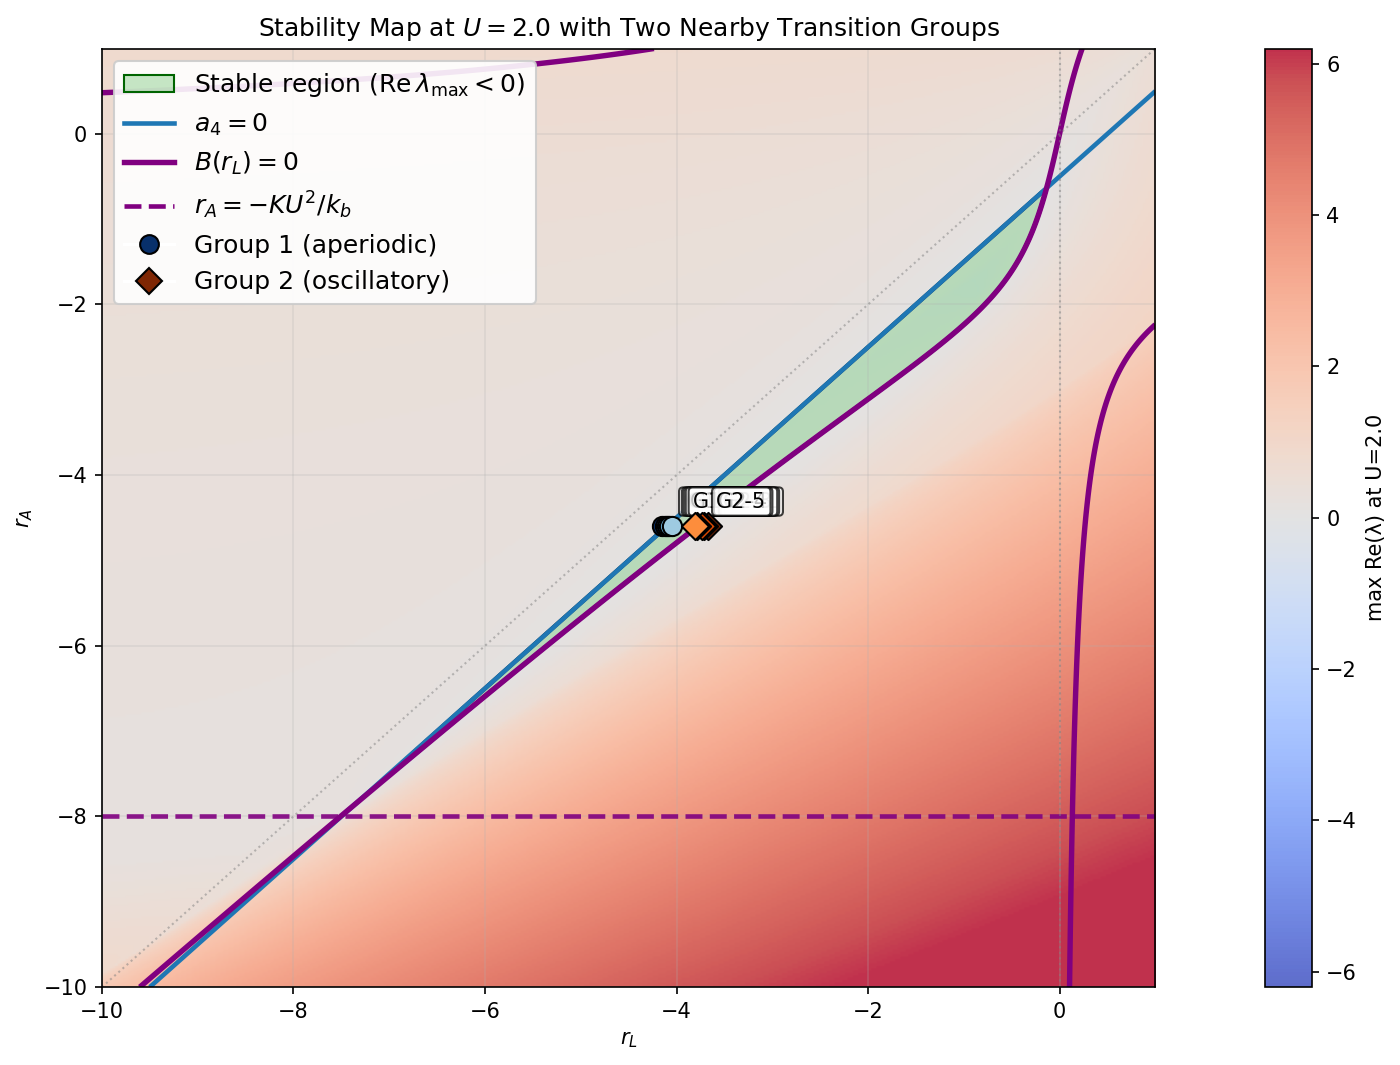

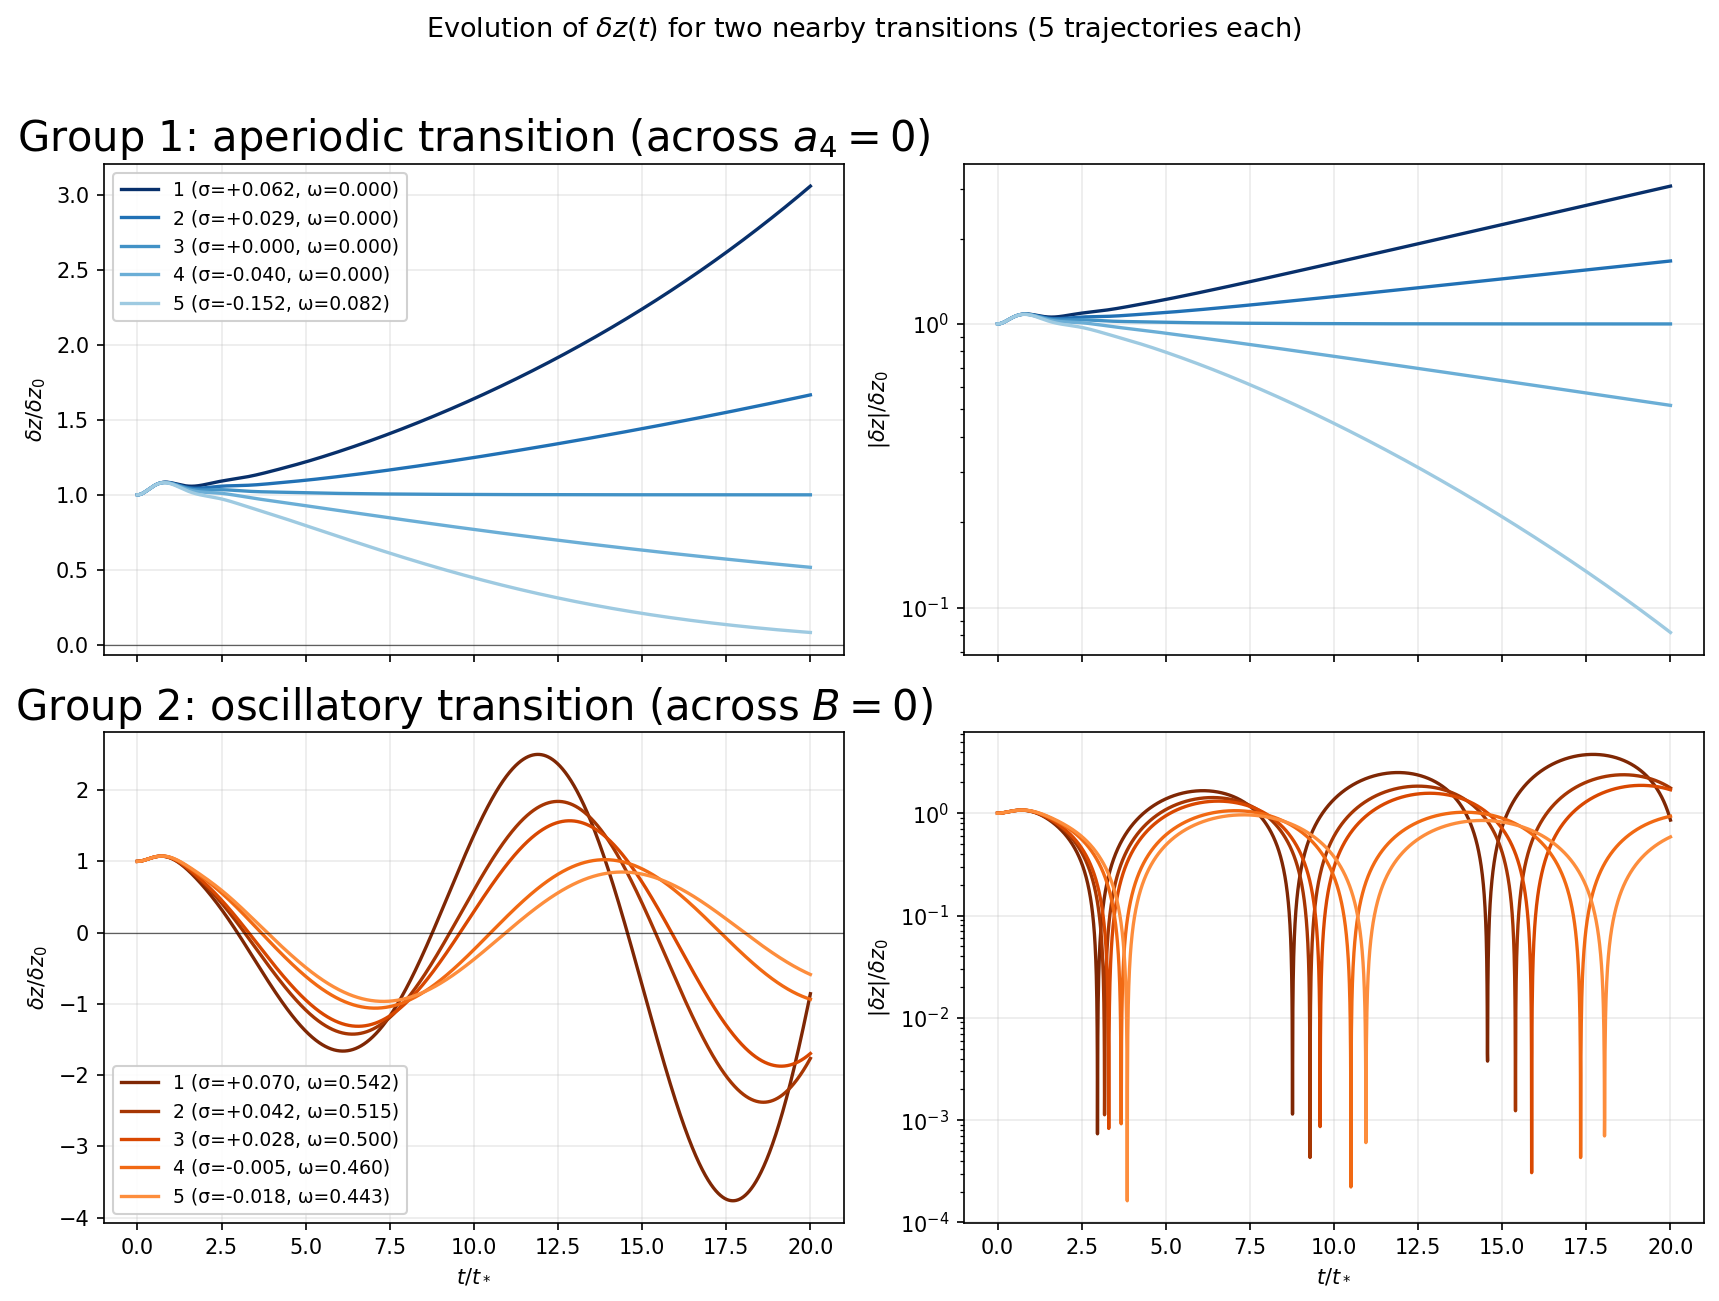

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

GLOBAL_FONT_SIZE = 20

# ---------------- Fixed velocity for the map ----------------
U_fixed_map_1 = 2.0  # map U and also scenario U below

# ---------------- Model parameters (fallbacks) ----------------
m       = globals().get('m', 1.0)
J       = globals().get('J', 0.1)
K       = globals().get('K', 1.0)
k_b     = globals().get('k_b', 0.5)
k_theta = globals().get('k_theta', 2.0)

# ---------------- System matrix A(U, r_L, r_A) ----------------
def A_ulalb(U, r_L, r_A, m=m, J=J, K=K, k_b=k_b, k_theta=k_theta):
    return np.array([
        [0.0,         1.0,                                   0.0,                                   0.0],
        [k_b/m,     - K*U/m,               (k_b*r_A + K*U*U)/m,                                   0.0],
        [0.0,         0.0,                                   0.0,                                   1.0],
        [k_b*r_A/J, - (r_L*K*U)/J, (-k_theta + (r_A*r_A)*k_b + r_L*K*U*U)/J,                       0.0]
    ], dtype=float)

# ---------------- RH minors and auxiliary functions ----------------
def ai_D_all(U, r_L, r_A):
    a1 = K*U/m
    a2 = -k_b/m - (k_b*r_A**2)/J - (K*U*U*r_L)/J + k_theta/J
    a3 = (K*U)/(J*m) * (k_theta - k_b*r_A**2 + k_b*r_L*r_A)
    a4 = (k_b/(J*m)) * (K*U*U*(r_L - r_A) - k_theta)
    D2 = a1*a2 - a3                 # Δ2
    B  = (r_L - r_A)*(J*k_b + k_b*r_L*r_A*m) + k_theta*r_L*m
    D3 = -(K*K*U*U)/(J*J*m*m*m) * (K*U*U + k_b*r_A) * B   # Δ3 up to positive factor
    return a1, a2, a3, a4, D2, D3, B

# ---------------- Grid for (r_L, r_A) ----------------
r_L_min, r_L_max = -10.0, 1.0
r_A_min, r_A_max = -10.0, 1.0
nRL_plot, nRA_plot = 400, 400
RL_plot, RA_plot = np.meshgrid(
    np.linspace(r_L_min, r_L_max, nRL_plot),
    np.linspace(r_A_min, r_A_max, nRA_plot)
)

# ---------------- Heat map (max Re λ) at U_fixed_map_1 ----------------
max_real_map = np.empty_like(RL_plot)
for i in range(nRA_plot):
    for j in range(nRL_plot):
        eig = np.linalg.eigvals(A_ulalb(U_fixed_map_1, RL_plot[i, j], RA_plot[i, j]))
        max_real_map[i, j] = np.max(np.real(eig))

# RH pieces at U_fixed_map_1
a1, a2, a3, a4, D2, D3, B = ai_D_all(U_fixed_map_1, RL_plot, RA_plot)
eps = 1e-12
stable_mask_full = (a1 > eps) & (a2 > eps) & (a3 > eps) & (a4 > eps) & (D2 > eps) & (D3 > eps)

# ---------------- Figure 1: Stability map with groups ----------------
fig, ax = plt.subplots(figsize=(10, 7.2), dpi=150)

# Heatmap
lo, hi = np.percentile(max_real_map, [2, 98])
vmax = max(abs(lo), abs(hi))
norm = TwoSlopeNorm(vmin=-vmax, vcenter=0.0, vmax=vmax)
im = ax.imshow(
    max_real_map, extent=[r_L_min, r_L_max, r_A_min, r_A_max],
    origin='lower', aspect='auto', cmap='coolwarm', norm=norm, alpha=0.82
)
cbar = plt.colorbar(im, ax=ax, pad=0.08)
cbar.set_label(f'max Re(λ) at U={U_fixed_map_1:.1f}')

# Stable region (full RH)
neg_full = np.ma.masked_where(~stable_mask_full, stable_mask_full.astype(float))
ax.contourf(RL_plot, RA_plot, neg_full, levels=[0.5, 1.5], colors=['#8fd18f40'], alpha=0.5)

# Neutral spectrum Re(λ_max)=0
ax.contour(RL_plot, RA_plot, max_real_map, levels=[0.0], colors='k', linewidths=2)

# Decisive boundaries: a4=0 (blue), Δ3 branches (purple)
ax.contour(RL_plot, RA_plot, a4, levels=[0.0], colors='#1f77b4', linewidths=2.2)
r_A_line = -K*U_fixed_map_1**2 / k_b
ax.axhline(r_A_line, color='purple', ls='--', lw=2.2, alpha=0.9)
ax.contour(RL_plot, RA_plot, B, levels=[0.0], colors='purple', linestyles='-', linewidths=2.6)

# Guides
ax.plot([r_L_min, r_L_max], [r_L_min, r_L_max], color='gray', lw=1, ls=':', alpha=0.5)
ax.axvline(0.0, color='gray', lw=1, ls=':', alpha=0.5)

# ---------------- Two "nearby" transition groups (U = 2.0) ----------------
# Group 1: aperiodic transition across a4=0 (fixed r_A, vary r_L)
group1 = [(-4.1500, -4.6000),
          (-4.1200, -4.6000),
          (-4.1000, -4.6000),  # ~near a4=0
          (-4.0800, -4.6000),
          (-4.0500, -4.6000)]

# Group 2: oscillatory transition across B=0 (fixed r_A, vary r_L)
group2 = [(-3.6755, -4.6000),
          (-3.7155, -4.6000),
          (-3.7355, -4.6000),  # ~near B=0 (Δ3=0)
          (-3.7855, -4.6000),
          (-3.8055, -4.6000)]

# Colors/markers per point order within group
g1_colors = ['#08306b','#2171b5','#4292c6','#6baed6','#9ecae1']  # dark->light blue
g2_colors = ['#7f2704','#a63603','#d94801','#f16913','#fd8d3c']  # dark->light orange
g1_marker, g2_marker = 'o', 'D'

def scatter_group(points, colors, marker, label_prefix):
    for k, (rL, rA) in enumerate(points, start=1):
        ax.scatter([rL],[rA], s=85, c=[colors[k-1]], marker=marker, edgecolor='k', zorder=6)
        ax.text(rL+0.02*(r_L_max-r_L_min), rA+0.02*(r_A_max-r_A_min),
                f'{label_prefix}{k}', fontsize=10,
                bbox=dict(boxstyle="round,pad=0.2", facecolor='white', alpha=0.75))

scatter_group(group1, g1_colors, g1_marker, 'G1-')
scatter_group(group2, g2_colors, g2_marker, 'G2-')

# Formatting & legend
ax.set_xlim(r_L_min, r_L_max)
ax.set_ylim(r_A_min, r_A_max)
ax.set_xlabel(r'$r_L$')
ax.set_ylabel(r'$r_A$')
ax.set_title('Stability Map at $U=2.0$ with Two Nearby Transition Groups')
ax.grid(True, alpha=0.25)

legend_elements = [
    Patch(facecolor='#8fd18f80', edgecolor='darkgreen',
          label=r'Stable region ($\mathrm{Re}\,\lambda_{\max}<0$)'),
    Line2D([0],[0], color='#1f77b4', linewidth=2.2, label=r'$a_4=0$'),
    Line2D([0],[0], color='purple', linestyle='-',  linewidth=2.6, label=r'$B(r_L)=0$'),
    Line2D([0],[0], color='purple', linestyle='--', linewidth=2.2, label=r'$r_A=-KU^2/k_b$'),
    Line2D([0],[0], marker=g1_marker, color='w', markerfacecolor=g1_colors[0], markeredgecolor='k',
           markersize=9, label='Group 1 (aperiodic)'),
    Line2D([0],[0], marker=g2_marker, color='w', markerfacecolor=g2_colors[0], markeredgecolor='k',
           markersize=9, label='Group 2 (oscillatory)'),
]
ax.legend(handles=legend_elements, loc='upper left', fontsize=12, framealpha=0.9)

plt.tight_layout()
plt.show()

# ---------------- Time-domain evolution: 4 subplots (2 groups × 2 axes) ----------------
def integrate_linear(A, x0, T, n_steps):
    dt = T / (n_steps - 1)
    x  = x0.copy()
    traj = np.zeros((n_steps, len(x0)))
    for k in range(n_steps):
        traj[k] = x
        k1 = A @ x
        k2 = A @ (x + 0.5*dt*k1)
        k3 = A @ (x + 0.5*dt*k2)
        k4 = A @ (x + dt*k3)
        x  = x + (dt/6.0)*(k1 + 2*k2 + 2*k3 + k4)
    return traj

def simulate_dz(U, rL, rA, z0=1e-3, T_mult=20.0, n_steps=4000):
    t_star = np.sqrt(m/k_b)
    T = T_mult * t_star
    A_mat = A_ulalb(U, rL, rA)
    x0 = np.array([z0, 0.0, 0.0, 0.0], float)
    traj = integrate_linear(A_mat, x0, T, n_steps)
    t_nd = np.linspace(0.0, T, n_steps) / t_star
    z_nd = traj[:,0] / z0
    vals = np.linalg.eigvals(A_mat)
    lam  = vals[np.argmax(np.real(vals))]
    sigma = np.real(lam) * t_star
    omega = abs(np.imag(lam)) * t_star
    return t_nd, z_nd, sigma, omega

def plot_group(ax_lin, ax_log, group_points, colors, title):
    for k, (rL, rA) in enumerate(group_points, start=1):
        t, z, sigma, omega = simulate_dz(U_fixed_map_1, rL, rA, z0=1e-3, T_mult=20.0, n_steps=4000)
        lbl = f'{k} (σ={sigma:+.3f}, ω={omega:.3f})'
        ax_lin.plot(t, z, color=colors[k-1], lw=1.6, label=lbl)
        ax_log.semilogy(t, np.abs(z)+1e-14, color=colors[k-1], lw=1.6, label=lbl)
    ax_lin.axhline(0, color='k', lw=0.6, alpha=0.6)
    ax_lin.set_ylabel(r'$\delta z / \delta z_0$')
    ax_lin.set_title(title, fontsize=GLOBAL_FONT_SIZE)
    ax_lin.grid(alpha=0.25)
    ax_log.grid(alpha=0.25)
    ax_log.set_ylabel(r'$|\delta z| / \delta z_0$')
    ax_lin.legend(loc='best', fontsize=9, framealpha=0.9, ncol=1)

fig2, axes = plt.subplots(2, 2, figsize=(11.5, 8.8), dpi=150, sharex='col')
plot_group(axes[0,0], axes[0,1], group1, g1_colors, 'Group 1: aperiodic transition (across $a_4=0$)')
plot_group(axes[1,0], axes[1,1], group2, g2_colors, 'Group 2: oscillatory transition (across $B=0$)')

axes[1,0].set_xlabel(r'$t/t_*$')
axes[1,1].set_xlabel(r'$t/t_*$')

fig2.suptitle(r'Evolution of $\delta z(t)$ for two nearby transitions (5 trajectories each)', fontsize=13)
plt.savefig('scenario_2.png', dpi=300, bbox_inches='tight')
plt.tight_layout(rect=[0, 0.0, 1, 0.96])
plt.show()



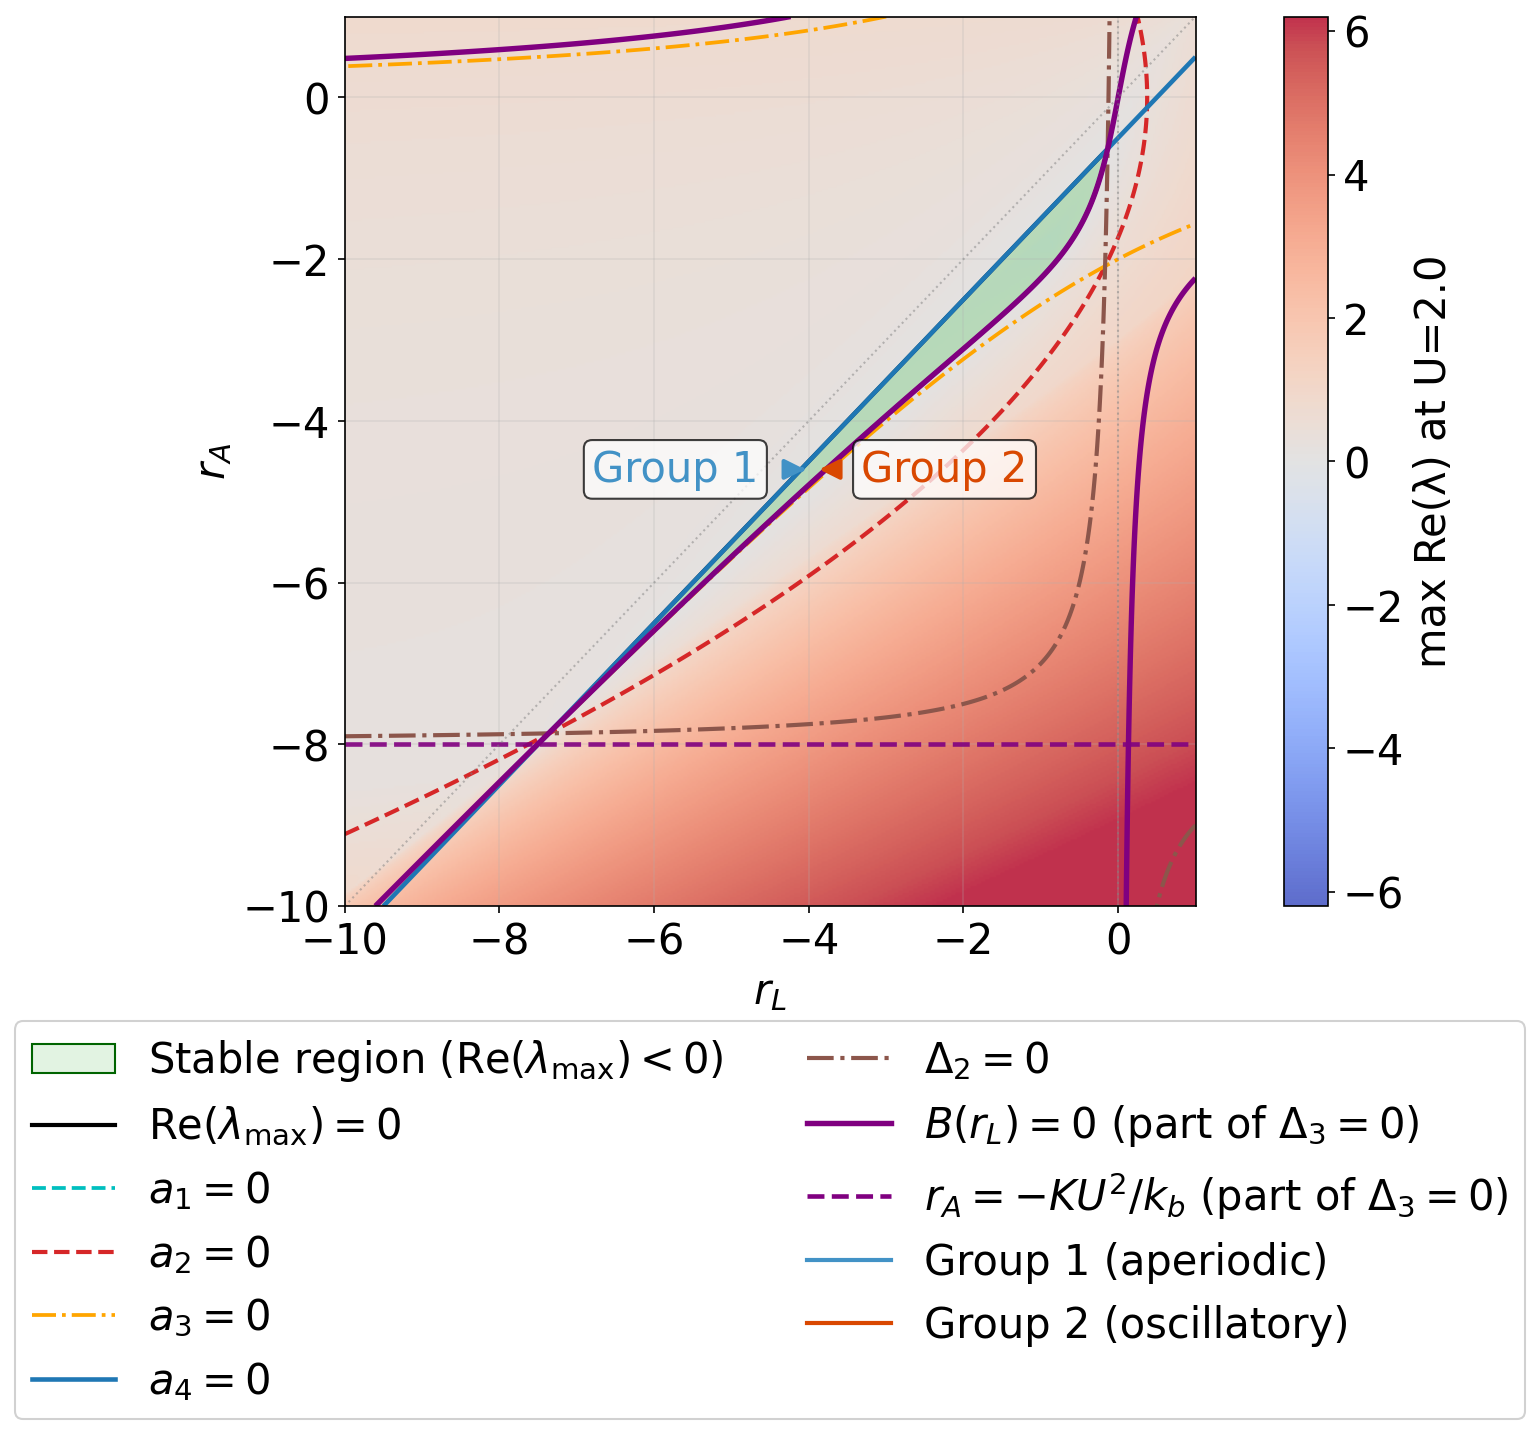

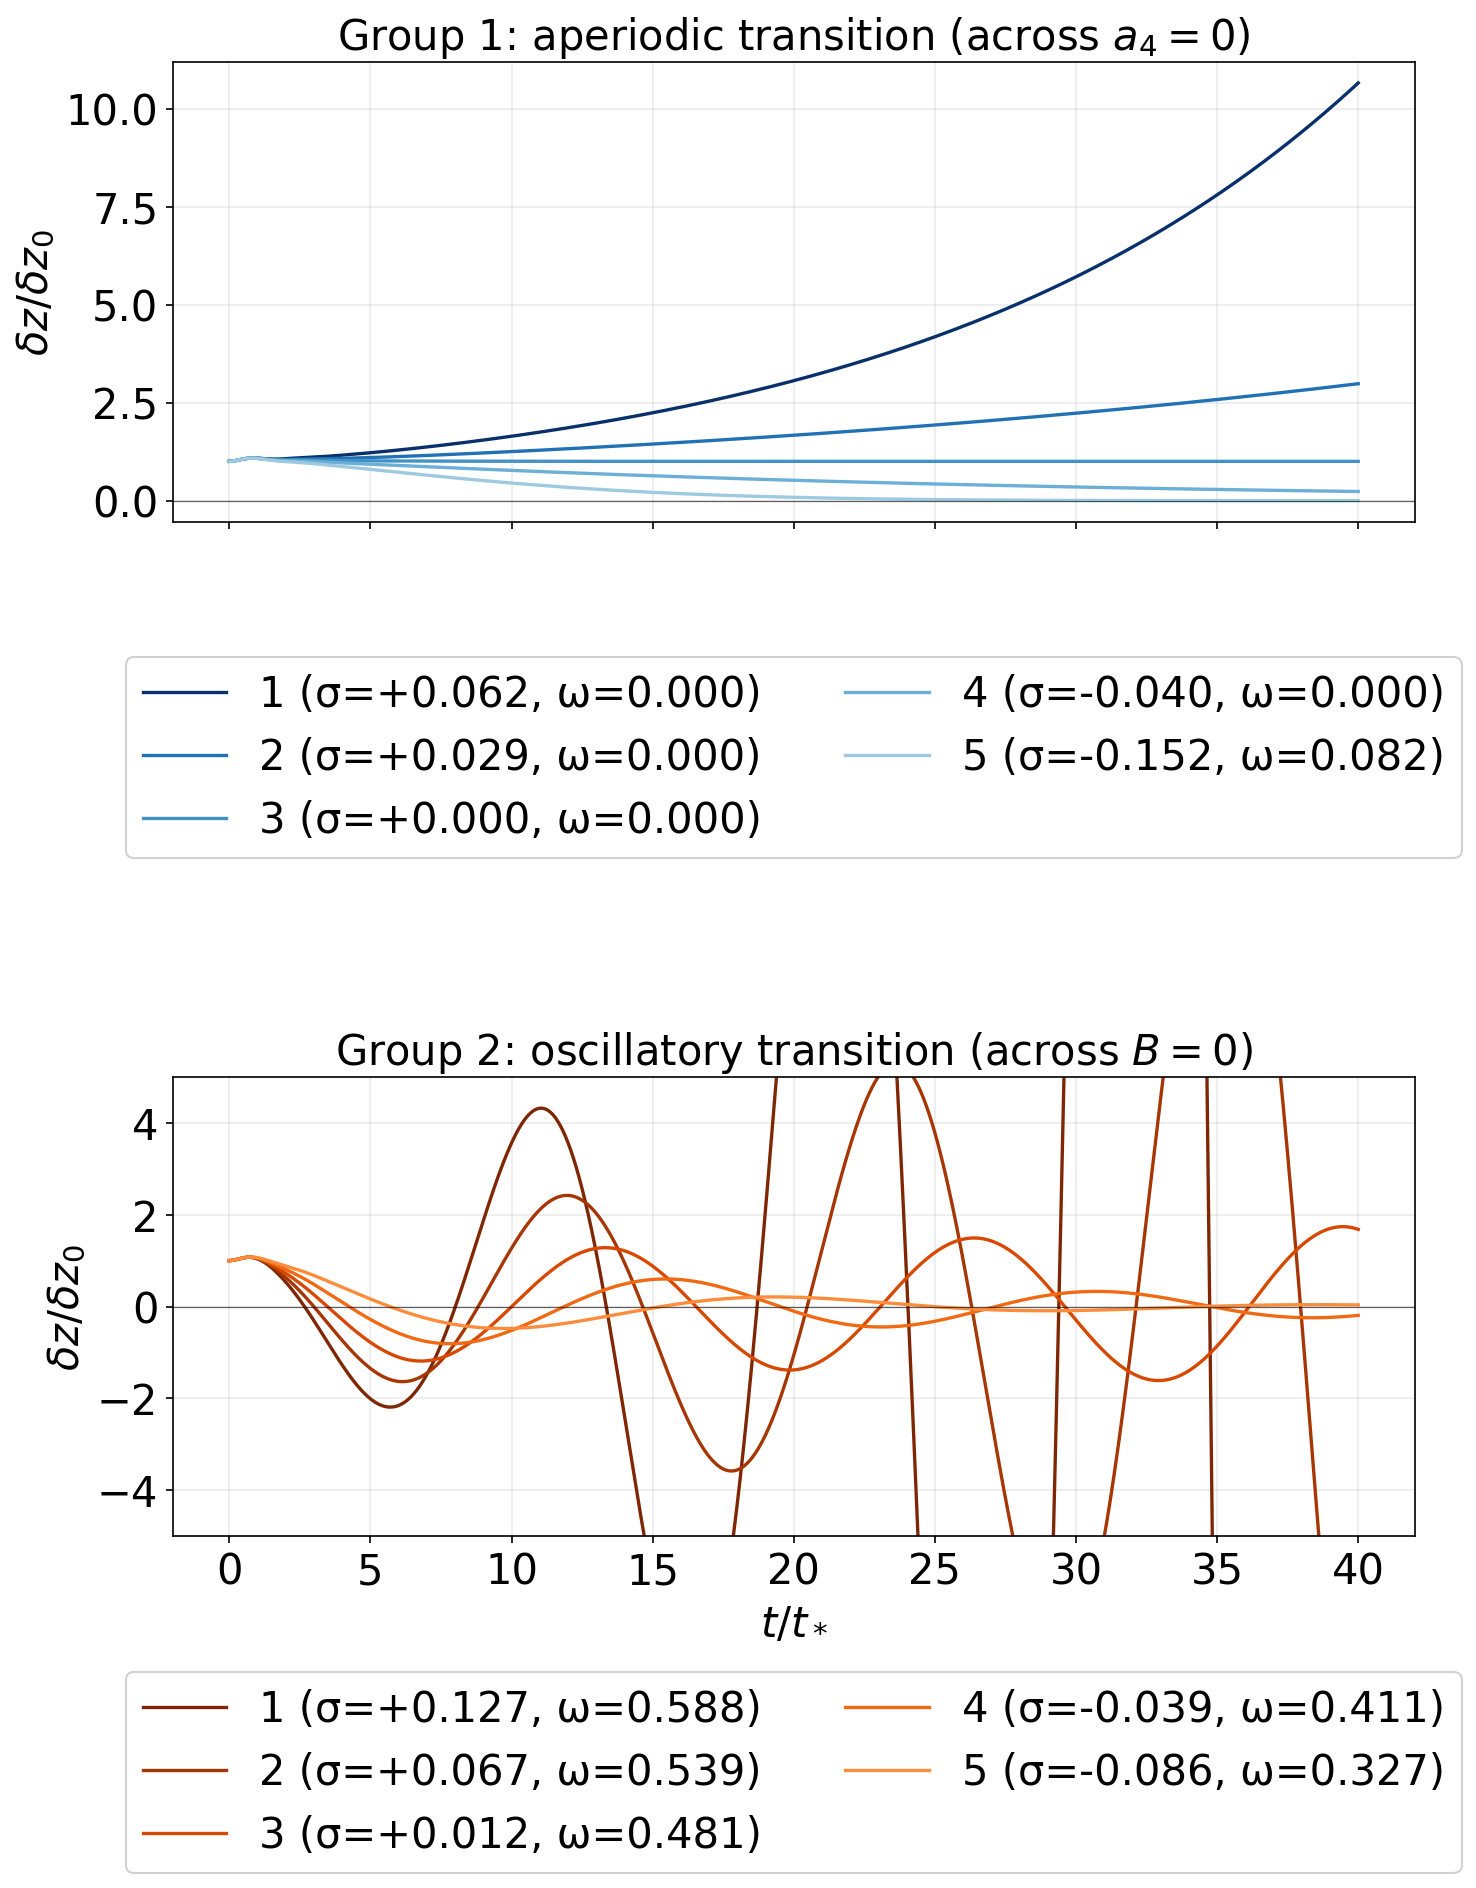

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib.patches import FancyArrowPatch

# ---------------- Fixed velocity for the map ----------------
U_fixed_map_1 = 2.0  # map U and also scenario U below

# ---------------- Model parameters (fallbacks) ----------------
m       = globals().get('m', 1.0)
J       = globals().get('J', 0.1)
K       = globals().get('K', 1.0)
k_b     = globals().get('k_b', 0.5)
k_theta = globals().get('k_theta', 2.0)

# ---------------- Global Font Size Variable ----------------
GLOBAL_FONT_SIZE = 20 # Adjust this value to change font size

# ---------------- Save PNG Flag ----------------
SAVE_PNG = True # Set to True to save figures as PNG files

# ---------------- System matrix A(U, r_L, r_A) ----------------
def A_ulalb(U, r_L, r_A, m=m, J=J, K=K, k_b=k_b, k_theta=k_theta):
    return np.array([
        [0.0,         1.0,                                   0.0,                                   0.0],
        [k_b/m,     - K*U/m,               (k_b*r_A + K*U*U)/m,                                   0.0],
        [0.0,         0.0,                                   0.0,                                   1.0],
        [k_b*r_A/J, - (r_L*K*U)/J, (-k_theta + (r_A*r_A)*k_b + r_L*K*U*U)/J,                       0.0]
    ], dtype=float)

# ---------------- RH minors and auxiliary functions ----------------
def ai_D_all(U, r_L, r_A):
    # Ensure U is broadcastable if it's a scalar and r_L, r_A are arrays
    U_arr = np.full_like(r_L, U) if np.isscalar(U) else U

    a1 = K*U_arr/m
    a2 = -k_b/m - (k_b*r_A**2)/J - (K*U_arr*U_arr*r_L)/J + k_theta/J
    a3 = (K*U_arr)/(J*m) * (k_theta - k_b*r_A**2 + k_b*r_L*r_A)
    a4 = (k_b/(J*m)) * (K*U_arr*U_arr*(r_L - r_A) - k_theta)
    D2 = a1*a2 - a3                 # Δ2
    B  = (r_L - r_A)*(J*k_b + k_b*r_L*r_A*m) + k_theta*r_L*m
    # Need to handle the speed multiplier term (K*U*U + k_b*r_A) which can be negative
    speed_multiplier = (K*U_arr*U_arr + k_b*r_A)
    D3 = -(K*K*U_arr*U_arr)/(J*J*m*m*m) * speed_multiplier * B   # Δ3 up to a positive factor

    return a1, a2, a3, a4, D2, D3, B

# ---------------- Grid for (r_L, r_A) ----------------
r_L_min, r_L_max = -10.0, 1.0
r_A_min, r_A_max = -10.0, 1.0
nRL_plot, nRA_plot = 400, 400
RL_plot, RA_plot = np.meshgrid(
    np.linspace(r_L_min, r_L_max, nRL_plot),
    np.linspace(r_A_min, r_A_max, nRA_plot)
)

# ---------------- Heat map (max Re λ) at U_fixed_map_1 ----------------
max_real_map = np.empty_like(RL_plot)
for i in range(nRA_plot):
    for j in range(nRL_plot):
        eig = np.linalg.eigvals(A_ulalb(U_fixed_map_1, RL_plot[i, j], RA_plot[i, j]))
        max_real_map[i, j] = np.max(np.real(eig))

# RH pieces at U_fixed_map_1
a1, a2, a3, a4, D2, D3, B = ai_D_all(U_fixed_map_1, RL_plot, RA_plot)
eps = 1e-12
stable_mask_full = (a1 > eps) & (a2 > eps) & (a3 > eps) & (a4 > eps) & (D2 > eps) & (D3 > eps)

# ---------------- Figure 1: Stability map with RH zero-curves ----------------
fig, ax = plt.subplots(figsize=(10, 15.7), dpi=150) # Increase figure width for legend

# Heatmap
lo, hi = np.percentile(max_real_map, [2, 98])
vmax = max(abs(lo), abs(hi))
norm = TwoSlopeNorm(vmin=-vmax, vcenter=0.0, vmax=vmax)
im = ax.imshow(
    max_real_map, extent=[r_L_min, r_L_max, r_A_min, r_A_max],
    origin='lower', aspect='auto', cmap='coolwarm', norm=norm, alpha=0.82
)
cbar = plt.colorbar(im, ax=ax, pad=0.08)
cbar.set_label(f'max Re(λ) at U={U_fixed_map_1:.1f}', fontsize=GLOBAL_FONT_SIZE)
cbar.ax.tick_params(labelsize=GLOBAL_FONT_SIZE)


# Stable region (full RH)
neg_full = np.ma.masked_where(~stable_mask_full, stable_mask_full.astype(float))
ax.contourf(RL_plot, RA_plot, neg_full, levels=[0.5, 1.5], colors=['#8fd18f40'], alpha=0.5)

# Neutral spectrum Re(λ_max)=0
ax.contour(RL_plot, RA_plot, max_real_map, levels=[0.0], colors='k', linewidths=2)

# --- All RH zero-curves ---
# a1=0 (cyan dashed) - Note: a1=KU/m, so a1=0 only if U=0 (unless K=0 or m=inf), which is likely outside the relevant range for this map.
# However, plotting it for completeness based on the request.
ax.contour(RL_plot, RA_plot, a1, levels=[0.0], colors='c', linestyles='--', linewidths=1.8)

# a2=0 (red dashed)
ax.contour(RL_plot, RA_plot, a2, levels=[0.0], colors='#d62728', linestyles='--', linewidths=2.0)

# a3=0 (orange dash-dot)
ax.contour(RL_plot, RA_plot, a3, levels=[0.0], colors='orange', linestyles='-.', linewidths=1.8)

# a4=0 (blue solid)
cs_a4 = ax.contour(RL_plot, RA_plot, a4, levels=[0.0], colors='#1f77b4', linewidths=2.2)

# Δ2=0 (brown dash-dot)
ax.contour(RL_plot, RA_plot, D2, levels=[0.0], colors='#8c564b', linestyles='-.', linewidths=2.0)

# Δ3=0 branches: r_A = -K U^2 / k_b (purple dashed) and B(r_L)=0 (purple solid)
r_A_line = -K*U_fixed_map_1**2 / k_b
ax.axhline(r_A_line, color='purple', ls='--', lw=2.2, alpha=0.9)
cs_B = ax.contour(RL_plot, RA_plot, B, levels=[0.0], colors='purple', linestyles='-', linewidths=2.6)

# Guides
ax.plot([r_L_min, r_L_max], [r_L_min, r_L_max], color='gray', lw=1, ls=':', alpha=0.5)
ax.axvline(0.0, color='gray', lw=1, ls=':', alpha=0.5)

# ---------------- Two "nearby" transition groups (U = 2.0) ----------------
# Group 1: aperiodic transition across a4=0 (fixed r_A, vary r_L)
group1 = [(-4.1500, -4.6000),
          (-4.1200, -4.6000),
          (-4.1000, -4.6000),  # ~near a4=0
          (-4.0800, -4.6000),
          (-4.0500, -4.6000)]

# Group 2: oscillatory transition across B=0 (fixed r_A, vary r_L)
group2 = [(-3.6000, -4.6000),
          (-3.6800, -4.6000),
          (-3.7600, -4.6000),  # ~near B=0 (Δ3=0)
          (-3.8400, -4.6000),
          (-3.9200, -4.6000)]

# Colors/markers per point order within group
g1_colors = ['#08306b','#2171b5','#4292c6','#6baed6','#9ecae1']  # dark->light blue
g2_colors = ['#7f2704','#a63603','#d94801','#f16913','#fd8d3c']  # dark->light orange
g1_marker, g2_marker = 'o', 'D'

# Add arrows and labels for groups
# Group 1 arrow (from left to right)
arrow1 = FancyArrowPatch(group1[0], group1[-1],
                         arrowstyle='-|>', mutation_scale=20, lw=2, color=g1_colors[2], zorder=7,
                         label='Group 1 (aperiodic)')
ax.add_patch(arrow1)
# Adjust text position and alignment for Group 1 (left of arrow)
ax.text(group1[0][0] - 0.5, group1[0][1], 'Group 1',
        color=g1_colors[2], fontsize=GLOBAL_FONT_SIZE, ha='right', va='center',
        bbox=dict(boxstyle="round,pad=0.2", facecolor='white', alpha=0.75))


# Group 2 arrow (from left to right)
arrow2 = FancyArrowPatch(group2[0], group2[-1],
                         arrowstyle='-|>', mutation_scale=20, lw=2, color=g2_colors[2], zorder=7,
                         label='Group 2 (oscillatory)')
ax.add_patch(arrow2)
# Adjust text position and alignment for Group 2 (right of arrow)
ax.text(group2[-1][0] + 0.6, group2[-1][1], 'Group 2',
        color=g2_colors[2], fontsize=GLOBAL_FONT_SIZE, ha='left', va='center',
        bbox=dict(boxstyle="round,pad=0.2", facecolor='white', alpha=0.75))


# Formatting & legend
ax.set_xlim(r_L_min, r_L_max)
ax.set_ylim(r_A_min, r_A_max)
ax.set_xlabel(r'$r_L$', fontsize=GLOBAL_FONT_SIZE)
ax.set_ylabel(r'$r_A$', fontsize=GLOBAL_FONT_SIZE)
# ax.set_title('Stability Map at $U={:.2f}$ with Routh-Hurwitz Zero-Curves and Two Nearby Transition Groups'.format(U_fixed_map_1), fontsize=GLOBAL_FONT_SIZE)
ax.grid(True, alpha=0.25)
ax.tick_params(axis='both', which='major', labelsize=GLOBAL_FONT_SIZE)


legend_elements = [
    Patch(facecolor='#8fd18f40', edgecolor='darkgreen', label=r'Stable region ($\mathrm{Re}(\lambda_{\max})<0$)'),
    Line2D([0], [0], color='k', linewidth=2, label=r'$\mathrm{Re}(\lambda_{\max})=0$'),
    Line2D([0], [0], color='c', linestyle='--', linewidth=1.8, label=r'$a_1=0$'),
    Line2D([0], [0], color='#d62728', linestyle='--', linewidth=2.0, label=r'$a_2=0$'),
    Line2D([0], [0], color='orange', linestyle='-.', linewidth=1.8, label=r'$a_3=0$'),
    Line2D([0], [0], color='#1f77b4', linewidth=2.2, label=r'$a_4=0$'),
    Line2D([0], [0], color='#8c564b', linestyle='-.', linewidth=2.0, label=r'$\Delta_2=0$'),
    Line2D([0], [0], color='purple', linestyle='-', linewidth=2.6, label=r'$B(r_L)=0$ (part of $\Delta_3=0$)'),
    Line2D([0], [0], color='purple', linestyle='--', linewidth=2.2, label=r'$r_A=-KU^2/k_b$ (part of $\Delta_3=0$)'),
    Line2D([0], [0], color=g1_colors[2], lw=2, marker='None', linestyle='-', label='Group 1 (aperiodic)'),
    Line2D([0], [0], color=g2_colors[2], lw=2, marker='None', linestyle='-', label='Group 2 (oscillatory)'),

]
# Move legend outside to the bottom in a single row
ax.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5, -0.6),
          fontsize=GLOBAL_FONT_SIZE, framealpha=0.9, ncol=2)

plt.tight_layout(rect=[0, 0.15, 1, 1]) # Adjust layout to make room for the legend at the bottom
if SAVE_PNG:
    plt.savefig('stability_map_groups.png', dpi=300, bbox_inches='tight') # Added savefig
plt.show()

# ---------------- Time-domain evolution: 4 subplots (2 groups × 2 axes) ----------------
def integrate_linear(A, x0, T, n_steps):
    dt = T / (n_steps - 1)
    x  = x0.copy()
    traj = np.zeros((n_steps, len(x0)))
    for k in range(n_steps):
        traj[k] = x
        k1 = A @ x
        k2 = A @ (x + 0.5*dt*k1)
        k3 = A @ (x + 0.5*dt*k2)
        k4 = A @ (x + dt*k3)
        x  = x + (dt/6.0)*(k1 + 2*k2 + 2*k3 + k4)
    return traj

def simulate_dz(U, rL, rA, z0=1e-3, T_mult=20.0, n_steps=4000):
    t_star = np.sqrt(m/k_b)
    T = T_mult * t_star
    A_mat = A_ulalb(U, rL, rA)
    x0 = np.array([z0, 0.0, 0.0, 0.0], float)
    traj = integrate_linear(A_mat, x0, T, n_steps)
    t_nd = np.linspace(0.0, T, n_steps) / t_star
    z_nd = traj[:,0] / z0
    vals = np.linalg.eigvals(A_mat)
    lam  = vals[np.argmax(np.real(vals))]
    sigma = np.real(lam) * t_star
    omega = abs(np.imag(lam)) * t_star
    return t_nd, z_nd, sigma, omega

def plot_group(ax_lin, group_points, colors, title):
    for k, (rL, rA) in enumerate(group_points, start=1):
        t, z, sigma, omega = simulate_dz(U_fixed_map_1, rL, rA, z0=1e-3, T_mult=40.0, n_steps=4000)
        lbl = f'{k} (σ={sigma:+.3f}, ω={omega:.3f})'
        ax_lin.plot(t, z, color=colors[k-1], lw=1.6, label=lbl)
    ax_lin.axhline(0, color='k', lw=0.6, alpha=0.6)
    ax_lin.set_ylabel(r'$\delta z / \delta z_0$', fontsize=GLOBAL_FONT_SIZE)
    ax_lin.set_title(title, fontsize=GLOBAL_FONT_SIZE)
    ax_lin.grid(alpha=0.25)
    ax_lin.legend(loc='upper center', bbox_to_anchor=(0.5, -0.25), # Adjusted bbox_to_anchor
                  fontsize=GLOBAL_FONT_SIZE, framealpha=0.9, ncol=2) # Set ncol to 2
    ax_lin.tick_params(axis='both', which='major', labelsize=GLOBAL_FONT_SIZE)


fig2, axes = plt.subplots(2, 1, figsize=(10, 18), dpi=150, sharex='col')
plot_group(axes[0], group1, g1_colors, 'Group 1: aperiodic transition (across $a_4=0$)')
plot_group(axes[1], group2, g2_colors, 'Group 2: oscillatory transition (across $B=0$)')
plt.ylim(-5, 5)
axes[1].set_xlabel(r'$t/t_*$', fontsize=GLOBAL_FONT_SIZE)

# fig2.suptitle(r'Evolution of $\delta z(t)$ for two nearby transitions (5 trajectories each)', fontsize=GLOBAL_FONT_SIZE)
# Adjusted tight_layout for the second figure to make space for legends
plt.subplots_adjust(hspace=0.05, bottom=0.08)  # hspace - расстояние между subplots
plt.tight_layout(rect=[0, 0.2, 1, 0.96]) # Increased bottom margin in rect
if SAVE_PNG:
    plt.savefig('time_evolution_groups.png', dpi=300, bbox_inches='tight') # Added savefig
plt.show()

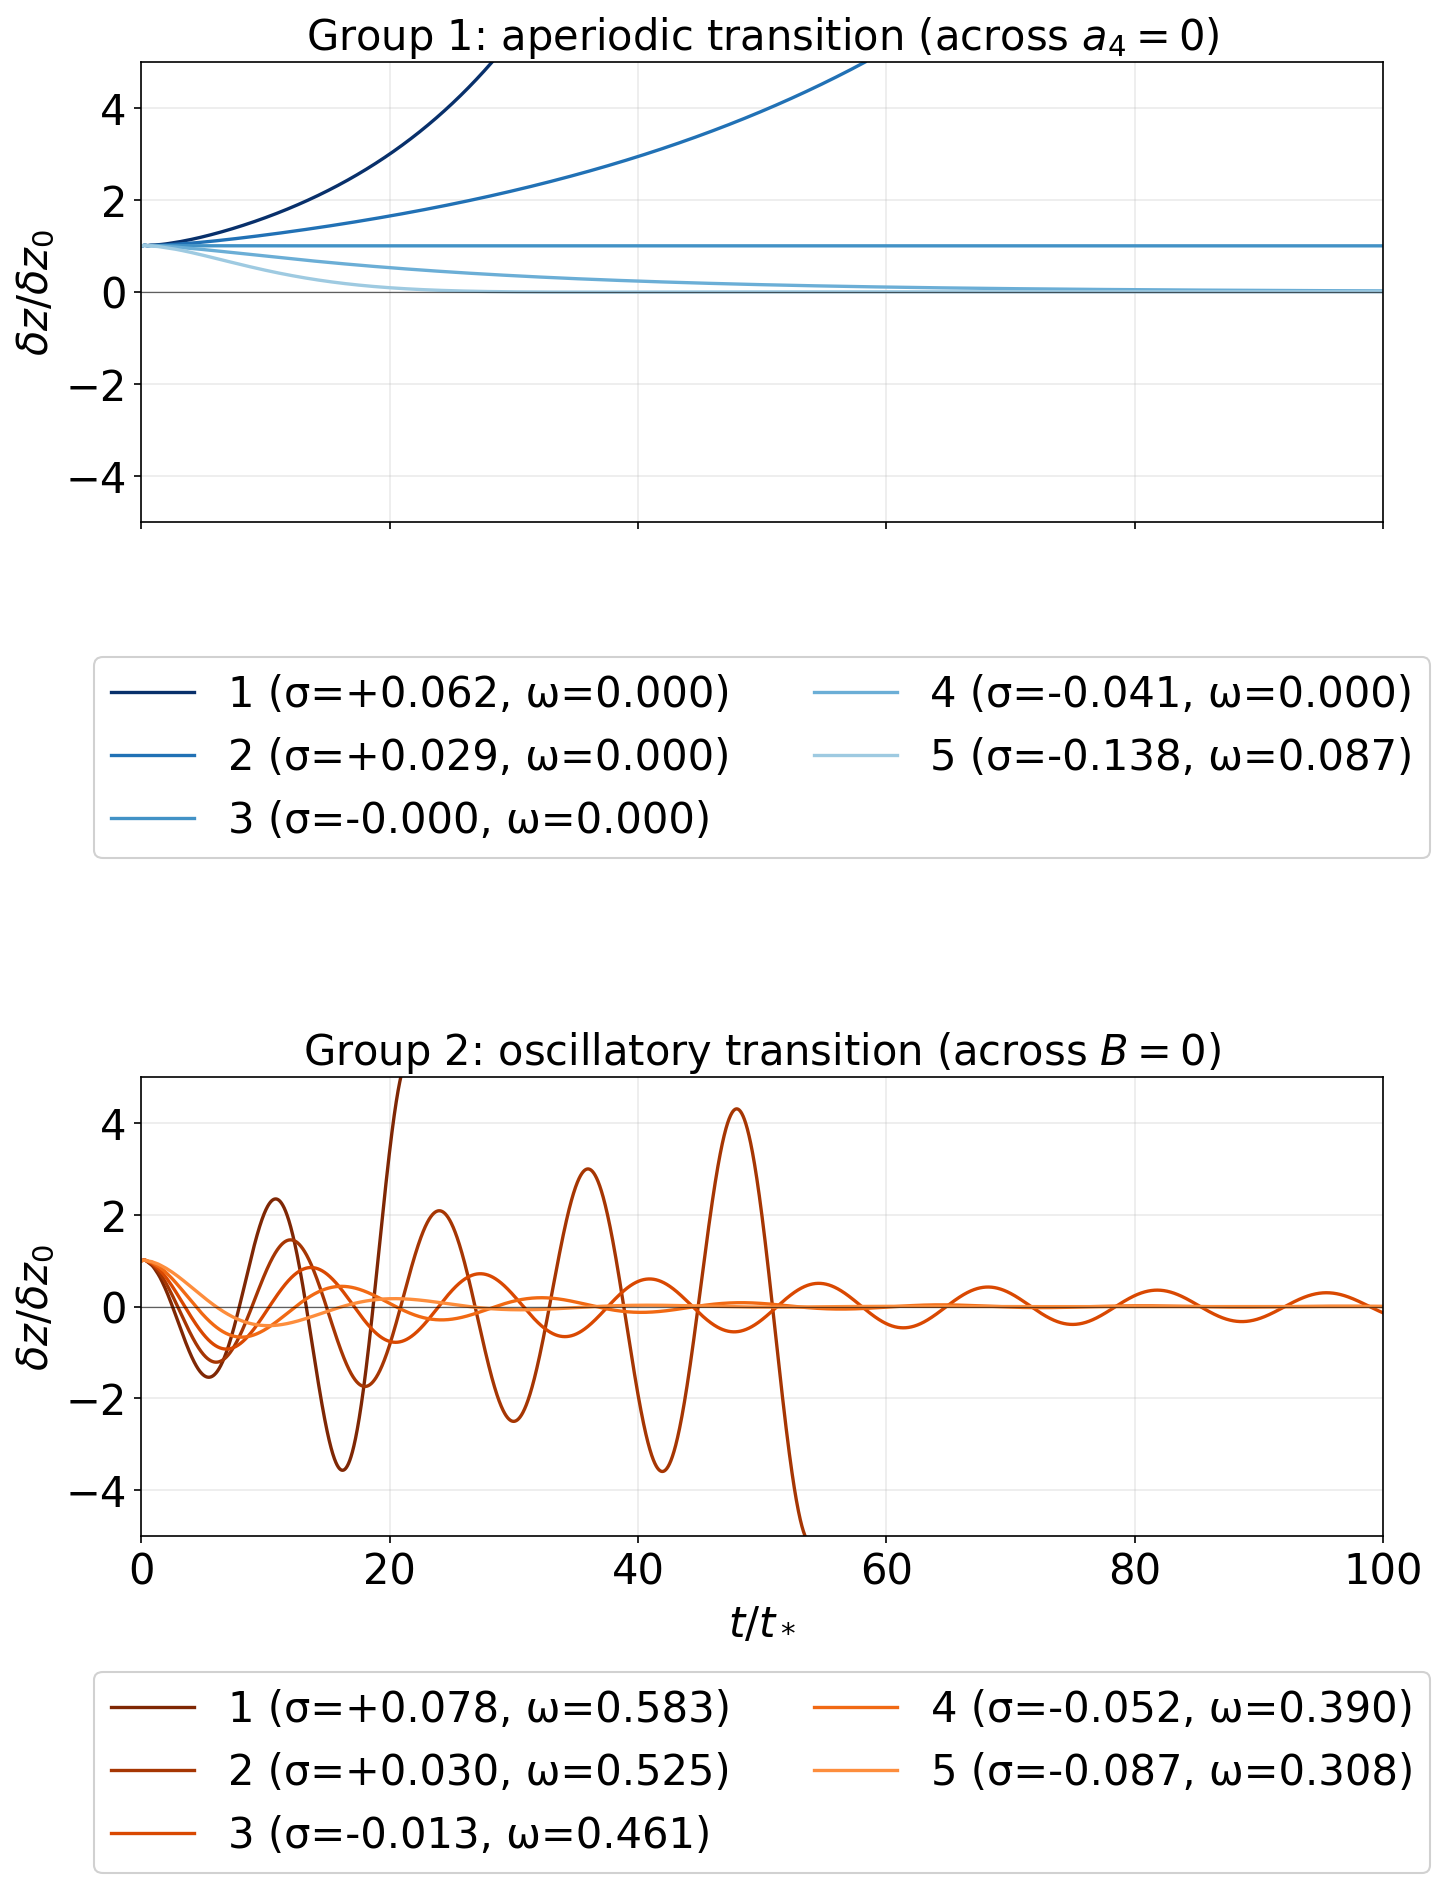

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ---------------- Model parameters (standalone) ----------------
U_fixed = 2.0
m       = 1.0
J       = 0.1
K       = 1.0
k_b     = 0.5
k_theta = 2.0

# ---------------- Display & integration settings ----------------
GLOBAL_FONT_SIZE = 20
SAVE_PNG         = True
YMAX             = 5.0          # vertical bounds [-5, +5]
T_MULT_ND        = 100.0        # longer time horizon in t/t*
N_STEPS          = 6000

# ---------------- System matrix A(U, r_L, r_A) ----------------
def A_ulalb(U, r_L, r_A, m=m, J=J, K=K, k_b=k_b, k_theta=k_theta):
    return np.array([
        [0.0,         1.0,                                   0.0,                                   0.0],
        [k_b/m,     - K*U/m,               (k_b*r_A + K*U*U)/m,                                   0.0],
        [0.0,         0.0,                                   0.0,                                   1.0],
        [k_b*r_A/J, - (r_L*K*U)/J, (-k_theta + (r_A*r_A)*k_b + r_L*K*U*U)/J,                       0.0]
    ], dtype=float)

# ---------------- RK4 integrator for x' = A x ----------------
def integrate_linear(A, x0, T, n_steps):
    dt   = T / (n_steps - 1)
    x    = x0.copy()
    traj = np.zeros((n_steps, len(x0)))
    for k in range(n_steps):
        traj[k] = x
        k1 = A @ x
        k2 = A @ (x + 0.5*dt*k1)
        k3 = A @ (x + 0.5*dt*k2)
        k4 = A @ (x + dt*k3)
        x  = x + (dt/6.0)*(k1 + 2*k2 + 2*k3 + k4)
    return traj

# ---------------- One-shot δz(t) simulation ----------------
def simulate_dz(U, rL, rA, z0=1e-3, T_mult_nd=T_MULT_ND, n_steps=N_STEPS):
    t_star = np.sqrt(m/k_b)
    T      = T_mult_nd * t_star
    A_mat  = A_ulalb(U, rL, rA)
    x0     = np.array([z0, 0.0, 0.0, 0.0], float)
    traj   = integrate_linear(A_mat, x0, T, n_steps)
    t_nd   = np.linspace(0.0, T, n_steps) / t_star
    z_nd   = traj[:,0] / z0

    vals   = np.linalg.eigvals(A_mat)
    lam    = vals[np.argmax(np.real(vals))]
    sigma  = np.real(lam) * t_star
    omega  = abs(np.imag(lam)) * t_star
    return t_nd, z_nd, sigma, omega

# ---------------- Two "nearby" transition groups ----------------
group1 = [(-4.1500, -4.6000),
          (-4.1200, -4.6000),
          (-4.1000, -4.6000),
          (-4.0800, -4.6000),
          (-4.0500, -4.6000)]

group2 = [(-3.6000, -4.6000),
          (-3.6800, -4.6000),
          (-3.7600, -4.6000),
          (-3.8400, -4.6000),
          (-3.9200, -4.6000)]

g1_colors = ['#08306b','#2171b5','#4292c6','#6baed6','#9ecae1']  # blues
g2_colors = ['#7f2704','#a63603','#d94801','#f16913','#fd8d3c']  # oranges

def plot_group(ax_lin, group_points, colors, title):
    for k, (rL, rA) in enumerate(group_points, start=1):
        t, z, sigma, omega = simulate_dz(U_fixed, rL, rA)
        # --- truncate when |z| leaves bounds ---
        idx_clip = np.where(np.abs(z) > YMAX)[0]
        if idx_clip.size > 0:
            end = max(1, idx_clip[0])
            t_plot, z_plot = t[:end], z[:end]
        else:
            t_plot, z_plot = t, z

        lbl = f'{k} (σ={sigma:+.3f}, ω={omega:.3f})'
        ax_lin.plot(t_plot, z_plot, lw=1.6, color=colors[k-1], label=lbl)

    ax_lin.axhline(0, color='k', lw=0.6, alpha=0.6)
    ax_lin.set_ylabel(r'$\delta z / \delta z_0$', fontsize=GLOBAL_FONT_SIZE)
    ax_lin.set_title(title, fontsize=GLOBAL_FONT_SIZE)
    ax_lin.grid(alpha=0.25)
    ax_lin.set_ylim(-YMAX, YMAX)
    ax_lin.set_xlim(0.0, T_MULT_ND)
    ax_lin.tick_params(axis='both', which='major', labelsize=GLOBAL_FONT_SIZE)
    # === Legend exactly as in your example ===
    ax_lin.legend(loc='upper center', bbox_to_anchor=(0.5, -0.25),
                  fontsize=GLOBAL_FONT_SIZE, framealpha=0.9, ncol=2)

# ---------------- Figure: 2 subplots stacked ----------------
fig2, axes = plt.subplots(2, 1, figsize=(10, 18), dpi=150, sharex='col')
plot_group(axes[0], group1, g1_colors, 'Group 1: aperiodic transition (across $a_4=0$)')
plot_group(axes[1], group2, g2_colors, 'Group 2: oscillatory transition (across $B=0$)')
axes[1].set_xlabel(r'$t/t_*$', fontsize=GLOBAL_FONT_SIZE)

# spacing identical pattern
plt.subplots_adjust(hspace=0.05, bottom=0.08)
plt.tight_layout(rect=[0, 0.2, 1, 0.96])

if SAVE_PNG:
    plt.savefig('time_evolution_groups.png', dpi=300, bbox_inches='tight')
plt.show()


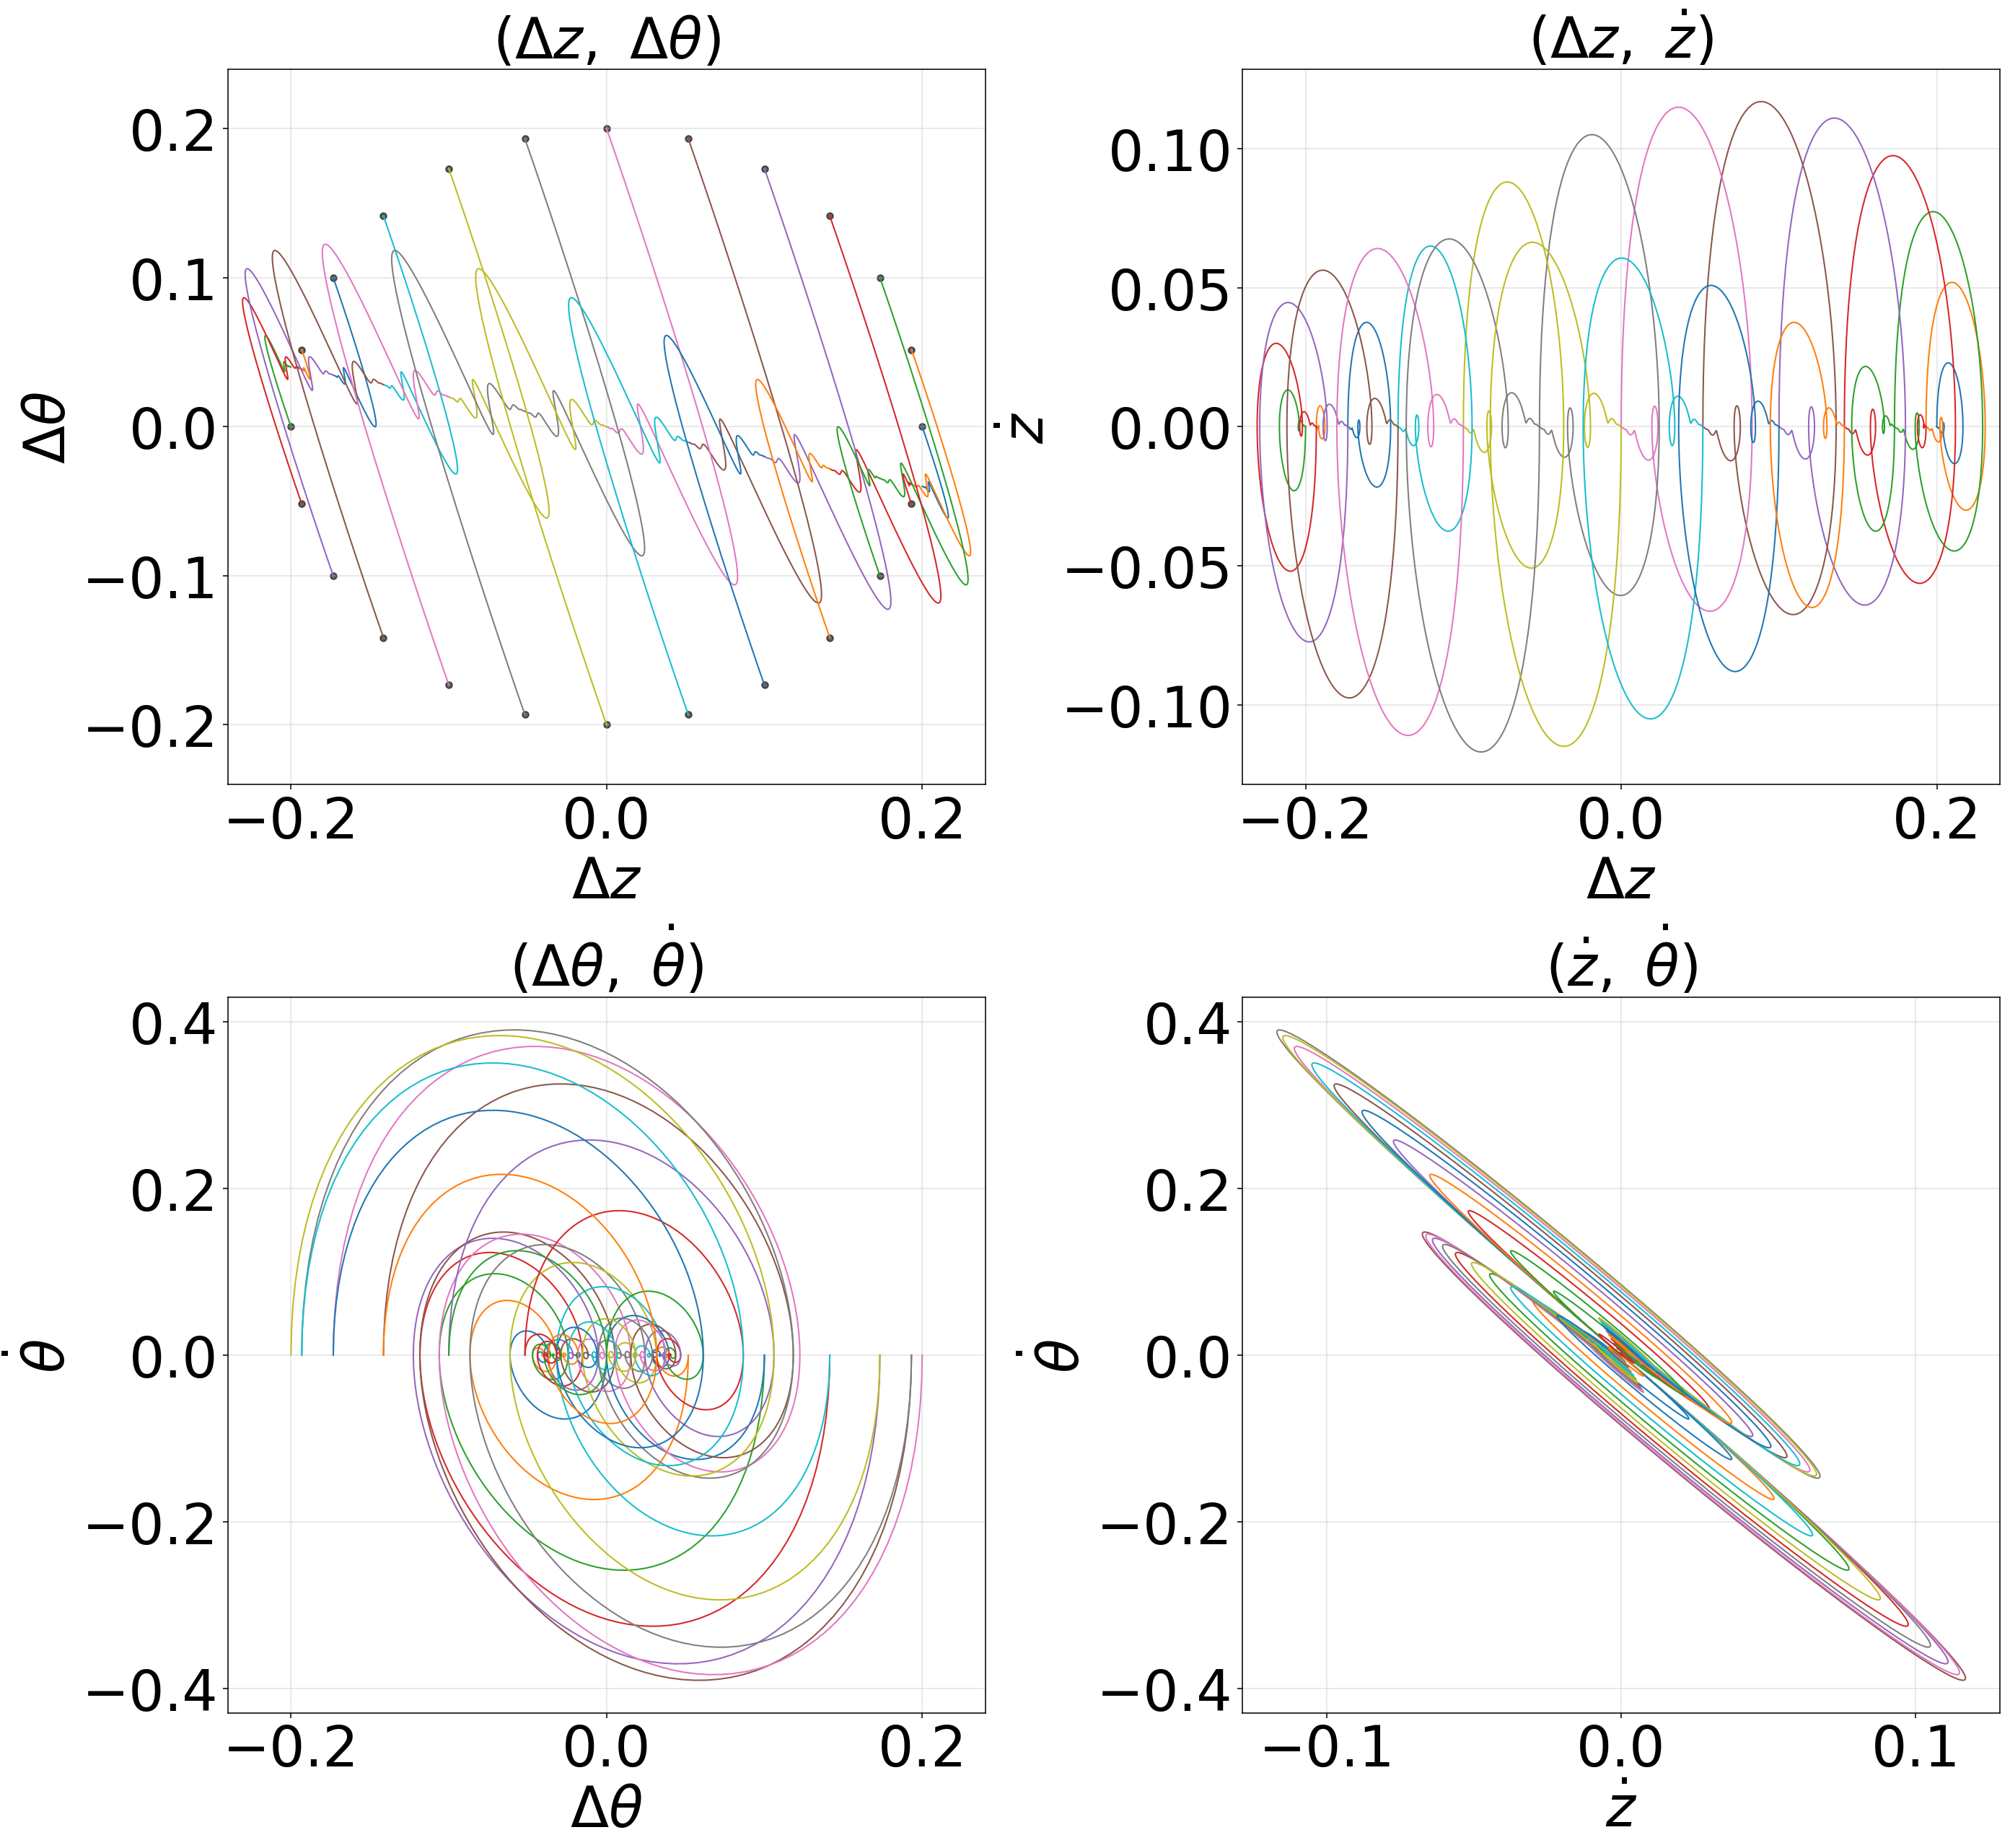

Начальные условия: окружность r0=0.2, N0=24.  l_a=-2.5, U≈2.0000.  Траекторий: 24.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ---------------- Global Font Size Variable ----------------
GLOBAL_FONT_SIZE = 40 # Adjust this value to change font size

# Попробуем SciPy; иначе — RK4
try:
    from scipy.integrate import solve_ivp
    _HAVE_SCIPY = True
except Exception:
    _HAVE_SCIPY = False

# -- Модель (берём A_matrix из окружения, иначе фолбэк) --
if 'A_matrix' not in globals():
    m = 1.0           # kg
    J = 1           # kg·m²
    k_b = 0.5        # N/m
    K = 1          # kg/m
    k_theta = 5.0     # N·m/rad
    r_A = -3       # m (bladder offset from CM)
    r_L_fixed = -2  # m (lift application offset)
    def A_matrix(U, l_a, m=m, J=J, K=K, k_b=k_b, l_b=r_A, k_theta=k_theta):
        return np.array([
            [0.0,           1.0,                                   0.0,                                  0.0],
            [k_b/m,       - K*U/m,                (k_b*l_b + K*U*U)/m,                                  0.0],
            [0.0,           0.0,                                   0.0,                                  1.0],
            [k_b*l_b/J,  - (l_a*K*U)/J, (-k_theta + (l_b*l_b)*k_b + l_a*K*U*U)/J,                        0.0]
        ], dtype=float)

if 'l_a_fixed' not in globals():
    l_a_fixed = -2.5
if 'U_min' not in globals(): U_min = 0.0
if 'U_max' not in globals(): U_max = 6.0

def max_real_part(U, l_a):
    eig = np.linalg.eigvals(A_matrix(U, l_a))
    return float(np.max(np.real(eig)))

U_sim = 2


def f_linear(t, x, U, l_a):
    return (A_matrix(U, l_a) @ x).astype(float)

# -- Настройка окружности начальных условий --
r0 = 0.20     # радиус окружности
N0 = 24      # число точек на окружности (равномерно)
angles = np.linspace(0.0, 2*np.pi, N0, endpoint=False)

# -- Интегрирование --
t_end  = 20.0
n_time = 1000
t_eval = np.linspace(0.0, t_end, n_time)

trajectories = []  # список массивов (4, n_time)
initial_conditions = [] # список массисов (4,)
for phi in angles:
    z0 = r0 * np.cos(phi)
    th0 = r0 * np.sin(phi)
    x0 = np.array([z0, 0.0, th0, 0.0], dtype=float)
    initial_conditions.append(x0)
    if _HAVE_SCIPY:
        sol = solve_ivp(f_linear, (0.0, t_end), x0, t_eval=t_eval,
                        args=(U_sim, l_a_fixed), rtol=1e-7, atol=1e-9)
        X = sol.y
    else:
        # RK4
        dt = t_eval[1] - t_eval[0]
        x = x0.copy()
        X = np.empty((4, n_time), dtype=float)
        for i, tt in enumerate(t_eval):
            X[:, i] = x
            k1 = f_linear(tt, x, U_sim, l_a_fixed)
            k2 = f_linear(tt+0.5*dt, x+0.5*dt*k1, U_sim, l_a_fixed)
            k3 = f_linear(tt+0.5*dt, x+0.5*dt*k2, U_sim, l_a_fixed)
            k4 = f_linear(tt+dt,     x+dt*k3,     U_sim, l_a_fixed)
            x += (dt/6.0)*(k1 + 2*k2 + 2*k3 + k4)
    trajectories.append(X)


# -- Рисуем 4 проекции в одной фигуре 2x2 --
fig, axes = plt.subplots(2, 2, figsize=(20, 20), dpi=140) # Adjusted figsize for potentially better layout
axes = axes.flatten() # Для удобства обращения по индексу

# --- 1) (Δz, Δθ) ---
ax1 = axes[0]
for X in trajectories:
    ax1.plot(X[0], X[2], lw=1.05)

# Нарисуем начальные условия
start_points = np.array([[r0 * np.cos(phi), r0 * np.sin(phi)] for phi in angles])
ax1.scatter(start_points[:, 0], start_points[:, 1], s=20, color='black', alpha=0.6)

ax1.set_xlabel(r'$\Delta z$', fontsize=GLOBAL_FONT_SIZE)
ax1.set_ylabel(r'$\Delta \theta$', fontsize=GLOBAL_FONT_SIZE)
ax1.set_title(r'$(\Delta z,\ \Delta \theta)$', fontsize=GLOBAL_FONT_SIZE)
ax1.grid(True, alpha=0.35)
# Set symmetric limits based on initial condition scale
limit_disp = 1.2 * r0
ax1.set_xlim(-limit_disp, limit_disp)
ax1.set_ylim(-limit_disp, limit_disp)
ax1.tick_params(axis='both', which='major', labelsize=GLOBAL_FONT_SIZE)


# --- 2) (Δz, ż) ---
ax2 = axes[1]
for X in trajectories:
    ax2.plot(X[0], X[1], lw=1.05)

ax2.set_xlabel(r'$\Delta z$', fontsize=GLOBAL_FONT_SIZE)
ax2.set_ylabel(r'$\dot z$', fontsize=GLOBAL_FONT_SIZE)
ax2.set_title(r'$(\Delta z,\ \dot z)$', fontsize=GLOBAL_FONT_SIZE)
ax2.grid(True, alpha=0.35)
ax2.set_xlim(-limit_disp, limit_disp)
# Automatic symmetric limits for velocity
all_dz_dot = np.concatenate([X[1] for X in trajectories])
ymax_dz_dot = np.max(np.abs(all_dz_dot)) if all_dz_dot.size > 0 else 1.0
ax2.set_ylim(-ymax_dz_dot*1.1, ymax_dz_dot*1.1)
ax2.tick_params(axis='both', which='major', labelsize=GLOBAL_FONT_SIZE)


# --- 3) (Δθ, θ̇) ---
ax3 = axes[2]
for X in trajectories:
    ax3.plot(X[2], X[3], lw=1.05)

ax3.set_xlabel(r'$\Delta \theta$', fontsize=GLOBAL_FONT_SIZE)
ax3.set_ylabel(r'$\dot \theta$', fontsize=GLOBAL_FONT_SIZE)
ax3.set_title(r'$(\Delta \theta,\ \dot \theta)$', fontsize=GLOBAL_FONT_SIZE)
ax3.grid(True, alpha=0.35)
ax3.set_xlim(-limit_disp, limit_disp)
# Automatic symmetric limits for velocity
all_dth_dot = np.concatenate([X[3] for X in trajectories])
ymax_dth_dot = np.max(np.abs(all_dth_dot)) if all_dth_dot.size > 0 else 1.0
ax3.set_ylim(-ymax_dth_dot*1.1, ymax_dth_dot*1.1)
ax3.tick_params(axis='both', which='major', labelsize=GLOBAL_FONT_SIZE)


# --- 4) (ż, θ̇) ---
ax4 = axes[3]
for X in trajectories:
    ax4.plot(X[1], X[3], lw=1.05)

ax4.set_xlabel(r'$\dot z$', fontsize=GLOBAL_FONT_SIZE)
ax4.set_ylabel(r'$\dot \theta$', fontsize=GLOBAL_FONT_SIZE)
ax4.set_title(r'$(\dot z,\ \dot \theta)$', fontsize=GLOBAL_FONT_SIZE)
ax4.grid(True, alpha=0.35)
# Automatic symmetric limits for velocities
all_dz_dot = np.concatenate([X[1] for X in trajectories])
all_dth_dot = np.concatenate([X[3] for X in trajectories])
ymax_dz_dot = np.max(np.abs(all_dz_dot)) if all_dz_dot.size > 0 else 1.0
ymax_dth_dot = np.max(np.abs(all_dth_dot)) if all_dth_dot.size > 0 else 1.0
ax4.set_xlim(-ymax_dz_dot*1.1, ymax_dz_dot*1.1)
ax4.set_ylim(-ymax_dth_dot*1.1, ymax_dth_dot*1.1)
ax4.tick_params(axis='both', which='major', labelsize=GLOBAL_FONT_SIZE)


# # Единый заголовок для всей фигуры
# fig.suptitle(f'Фазовые траектории при $l_a={l_a_fixed}$, $U\\approx{U_sim:.3f}$\nНачальные условия: окружность $r_0={r0}$', fontsize=GLOBAL_FONT_SIZE)

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Оставить место для suptitle
plt.savefig('phase_pr.png', dpi=200, bbox_inches='tight')
plt.show()

print(f"Начальные условия: окружность r0={r0}, N0={N0}.  l_a={l_a_fixed}, U≈{U_sim:.4f}.  Траекторий: {len(trajectories)}.")